In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot

from statsmodels.tsa.api import VAR

---

### 1) Problem 11.1

In [2]:
msa = pd.read_csv('fmhpi_master_file.csv', parse_dates=True)

In [3]:
msa1 = msa[msa['GEO_Name'] == 'Los Angeles-Long Beach-Anaheim CA']
msa2 = msa[msa['GEO_Name'] == 'San Diego-Carlsbad CA']

vars = ['Year', 'Month', 'GEO_Name', 'Index_NSA', 'Index_SA']
msa1 = msa1[vars]
msa2 = msa2[vars]

In [4]:
# Prep msa1 (Los Angeles)
msa1['date'] = msa1['Year'].astype(str) + '-' + msa1['Month'].astype(str) + '-' + '01'
msa1['date'] = pd.to_datetime(msa1['date'])
msa1 = msa1.set_index('date')
msa1 = msa1.drop(columns=['Year','Month'])
msa1.columns = ['Geo_name', 'LA_index_NSA', 'LA_index_SA']\

# Prep msa2 (San Diego)
msa2['date'] = msa2['Year'].astype(str) + '-' + msa2['Month'].astype(str) + '-' + '01'
msa2['date'] = pd.to_datetime(msa2['date'])
msa2 = msa2.set_index('date')
msa2 = msa2.drop(columns=['Year','Month'])
msa2.columns = ['Geo_name', 'SD_index_NSA', 'SD_index_SA']

In [5]:
# combine both series
df = pd.merge(msa1, msa2, left_index=True, right_index=True)

In [6]:
df.describe().T

count        mean        std        min        25%        50%  \
LA_index_NSA  579.0  132.636798  91.905348  15.742722  56.748235  92.427897   
LA_index_SA   579.0  131.805029  91.337507  15.708617  56.659633  91.910839   
SD_index_NSA  579.0  116.706025  80.611743  16.685657  48.322523  77.380913   
SD_index_SA   579.0  115.854580  80.031067  16.631256  48.168635  77.579404   

                     75%         max  
LA_index_NSA  203.133761  386.135585  
LA_index_SA   203.673601  379.834690  
SD_index_NSA  180.685167  354.455715  
SD_index_SA   178.491220  347.790103

In [7]:
df['LA_index_NSA'] = df['LA_index_NSA'].diff()
df['SD_index_NSA'] = df['SD_index_NSA'].diff()
df = df.dropna()

In [8]:
# ADF Test for Stationarity 

from statsmodels.tsa.stattools import adfuller

#Check stationarity for LA
adf = adfuller(df["LA_index_NSA"])[1] 
print(f"p value:{adf}", ", Series is Stationary" if adf < 0.05 else ", Series is Non-Stationary")

#Check stationarity of SD
adf = adfuller(df["SD_index_NSA"])[1] 
print(f"p value:{adf}", ", Series is Stationary" if adf < 0.05 else ", Series is Non-Stationary")

p value:0.0003582411422295481 , Series is Stationary
p value:0.0007356219648197005 , Series is Stationary


In [14]:
train = df.iloc[:-20]
test = df.iloc[-20:]

In [15]:
# Auto-fit Model
varLA = VAR(train[['LA_index_NSA', 'SD_index_NSA']], freq = 'MS').fit(maxlags = 15, ic = 'aic')
varSD = VAR(train[['SD_index_NSA', 'LA_index_NSA']], freq = 'MS').fit(maxlags = 15, ic = 'aic')

In [16]:
# Var Model: Lag Selection 
results = VAR(train[['LA_index_NSA', 'SD_index_NSA']]).fit(5)
results.summary() 

C:\Users\Josen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 26, May, 2023
Time:                     09:56:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.64741
Nobs:                     553.000    HQIC:                  -7.75202
Log likelihood:           614.632    FPE:                0.000401992
AIC:                     -7.81909    Det(Omega_mle):     0.000386465
--------------------------------------------------------------------
Results for equation LA_index_NSA
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.035316         0.019923            1.773           0.076
L1.LA_index_NSA         1.999900         0.347016            5.763           0.000
L1.SD_index_NSA        -0.284215         0.38

The fitted VAR model estimates a correlation between the LA and SD prices of .99, almost perfect correlation. The most optimal order is at lag 5. 

In [22]:
len(results.fittedvalues['LA_indeddx_NSA'])

553

[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'Residuals')]

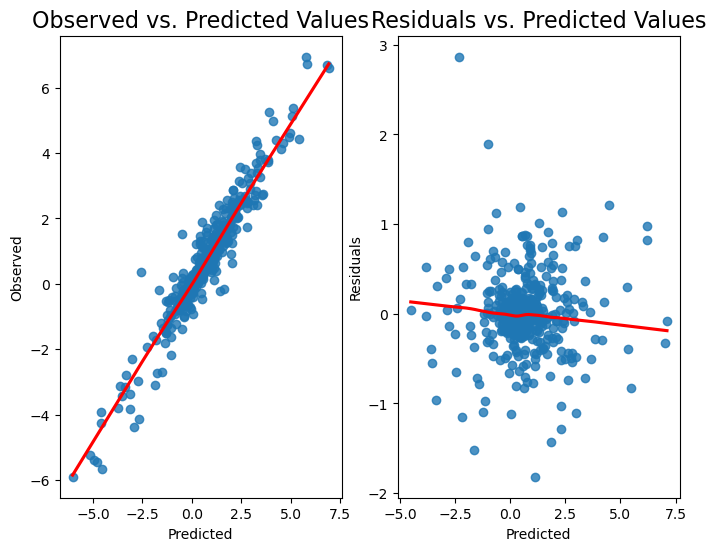

In [29]:
fig, ax = plt.subplots(1,2,figsize=(8, 6))
sns.regplot(x=results.fittedvalues['LA_index_NSA'].values, y=train['LA_index_NSA'][5:], lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
ax[0].set(xlabel='Predicted', ylabel='Observed')

sns.regplot(x=results.fittedvalues['SD_index_NSA'].values, y=results.resid['SD_index_NSA'].values, lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
ax[1].set(xlabel='Predicted', ylabel='Residuals')

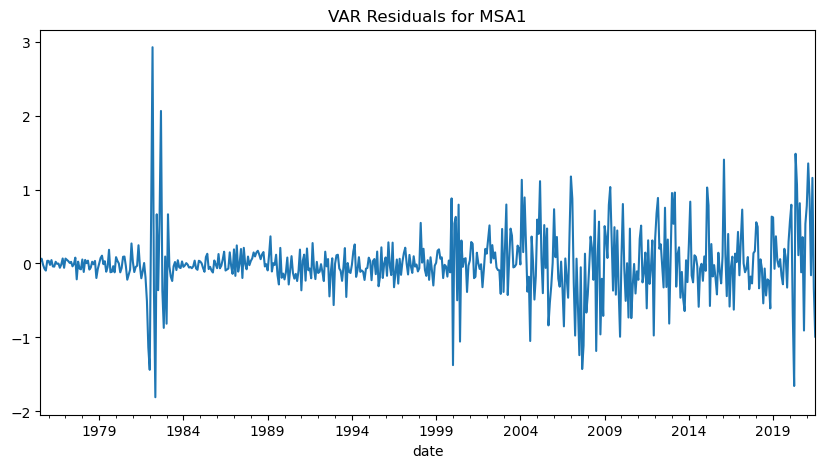

In [30]:
N, M = 10, 5
fig, ax = plt.subplots(figsize=(N, M))
results.resid['LA_index_NSA'].plot()
plt.title('VAR Residuals for MSA1')
plt.show()

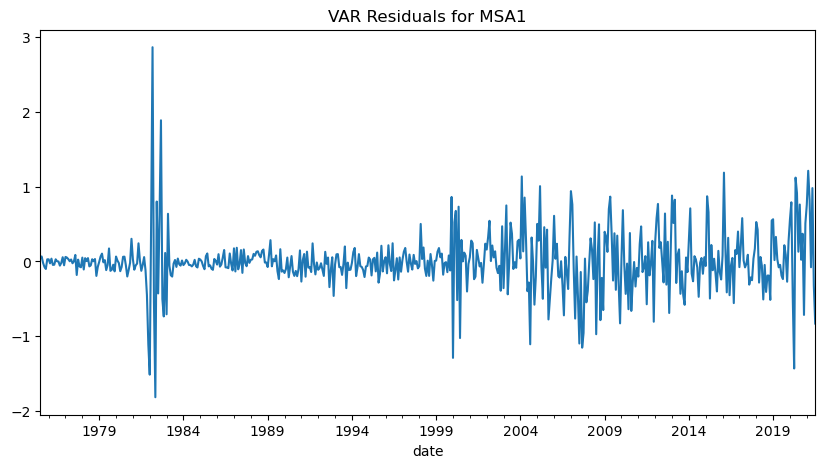

In [31]:
N, M = 10, 5
fig, ax = plt.subplots(figsize=(N, M))
results.resid['SD_index_NSA'].plot()
plt.title('VAR Residuals for MSA1')
plt.show()

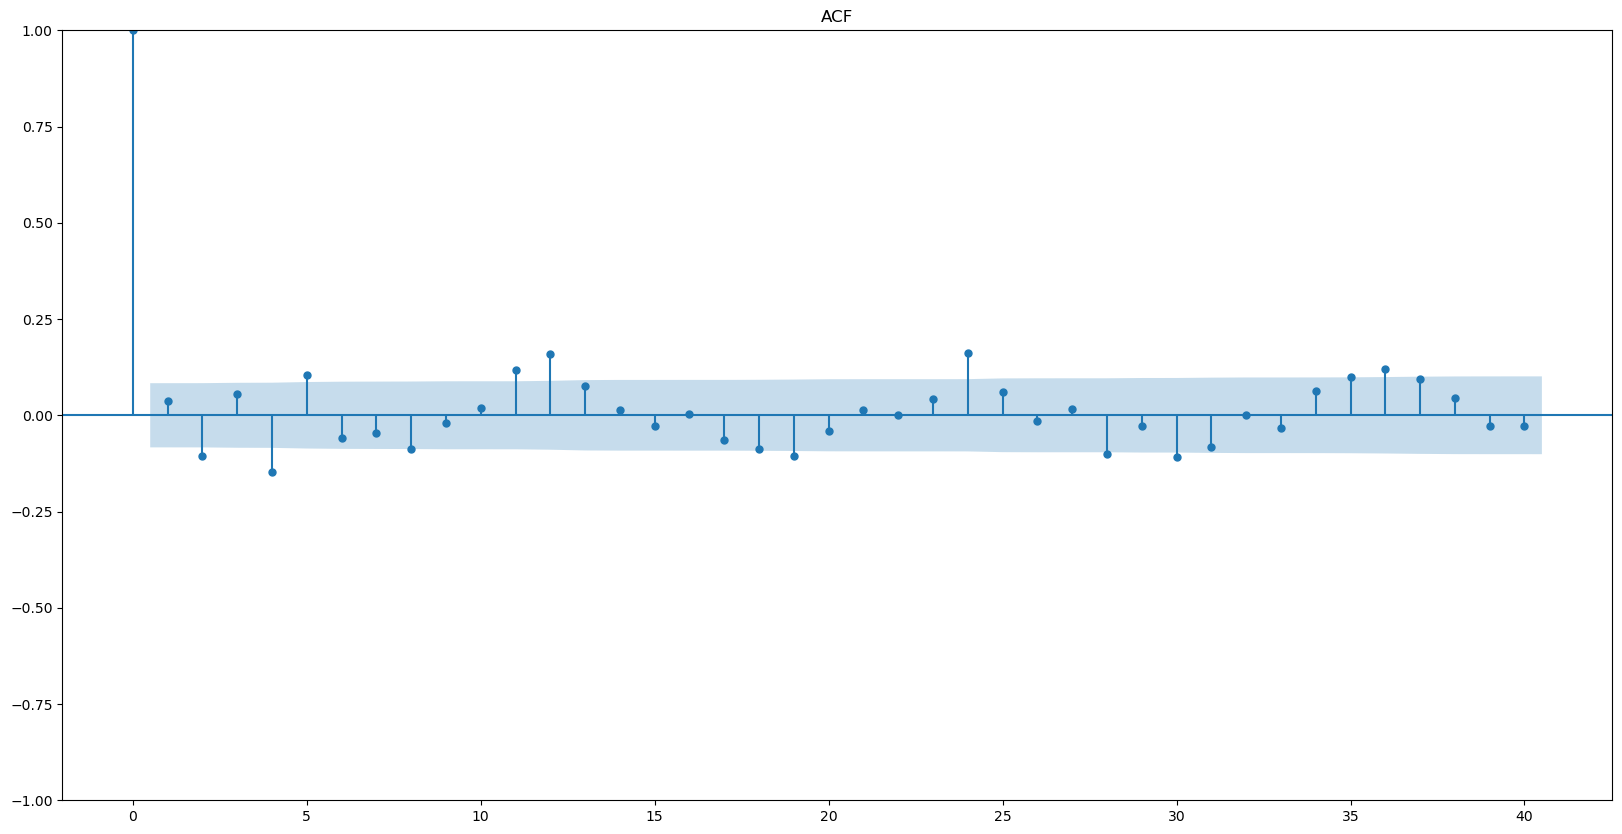

In [32]:
# LA_index_NSA ACF
N, M = 20, 10
fig, ax = plt.subplots(figsize=(N, M))
plot_acf(results.resid['LA_index_NSA'],title='ACF',lags=40, ax=ax)
plt.show()

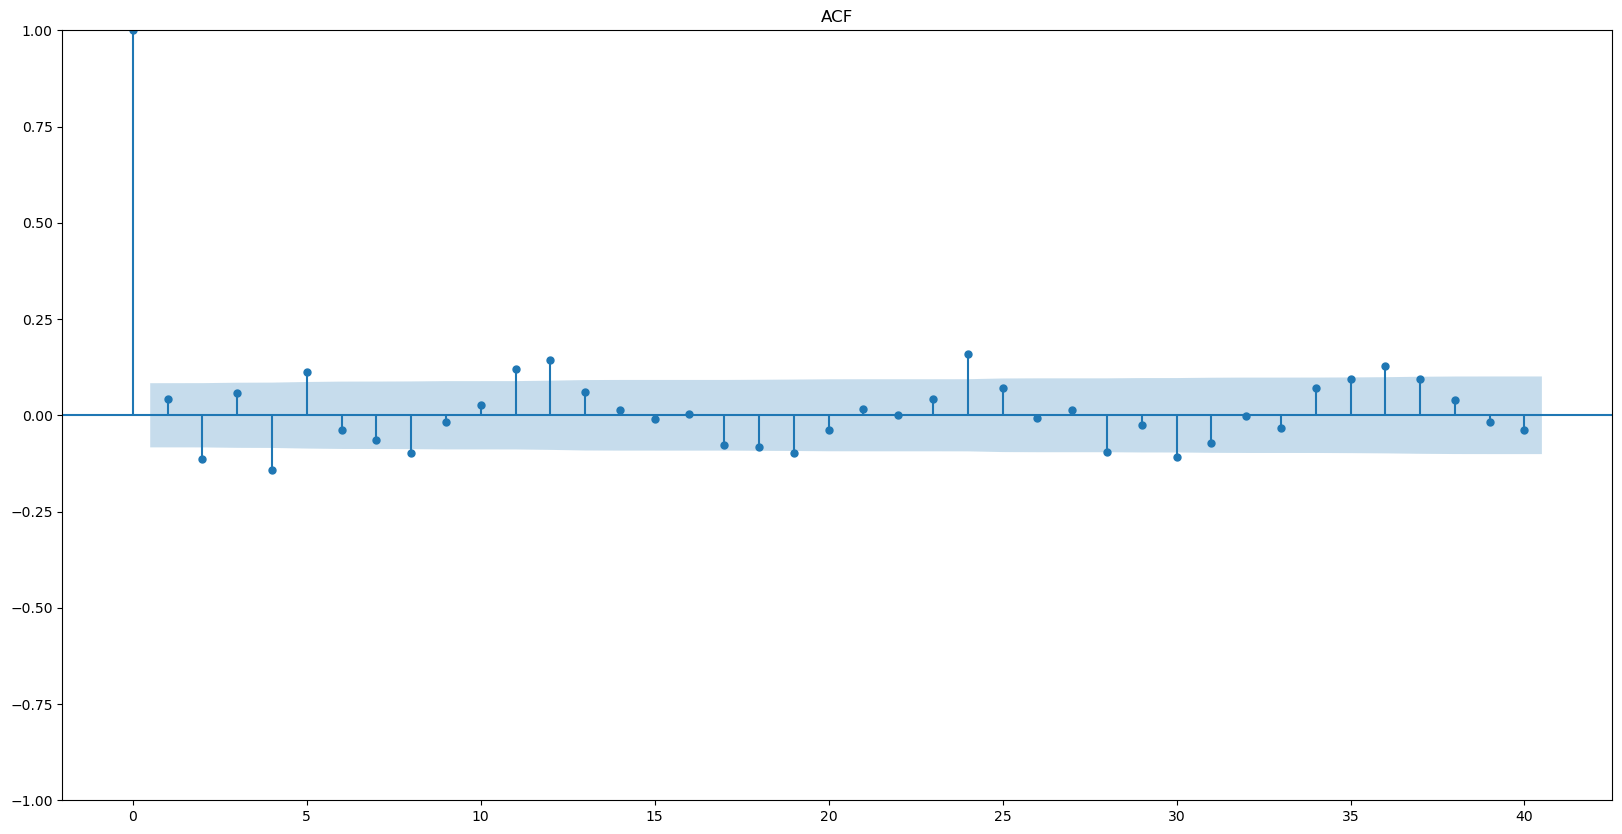

In [33]:
# SD_index_NSA ACF
N, M = 20, 10
fig, ax = plt.subplots(figsize=(N, M))
plot_acf(results.resid['SD_index_NSA'],title='ACF',lags=40, ax=ax)
plt.show()

---

## 2) Problem 11.2

### Granger-Causality Test

In [11]:
print(varLA.test_causality('LA_index_NSA', 'SD_index_NSA', kind = 'f').summary())

Granger causality F-test. H_0: SD_index_NSA does not Granger-cause LA_index_NSA. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         3.000          1.676   0.000 (15, 1064)
------------------------------------------------


In [12]:
print(varSD.test_causality('LA_index_NSA', 'SD_index_NSA', kind = 'f').summary())

Granger causality F-test. H_0: SD_index_NSA does not Granger-cause LA_index_NSA. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df    
------------------------------------------------
         3.000          1.676   0.000 (15, 1064)
------------------------------------------------


Since we reject the null hypothesis for the Granger-Causality test for both series, we can say that they each do have an effect on each other.

---

### 3) Problem 11.3

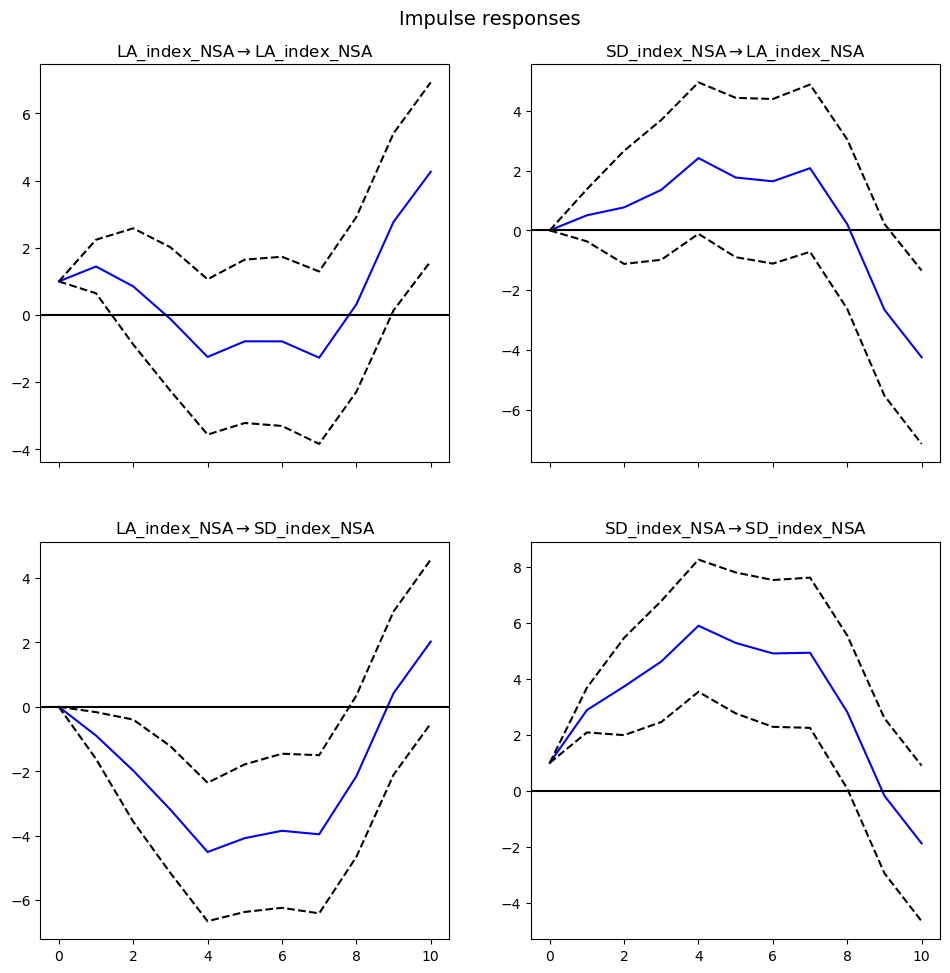

In [13]:
# IRFs 
irfN = varLA.irf(10) 
irfN.plot(orth = False);

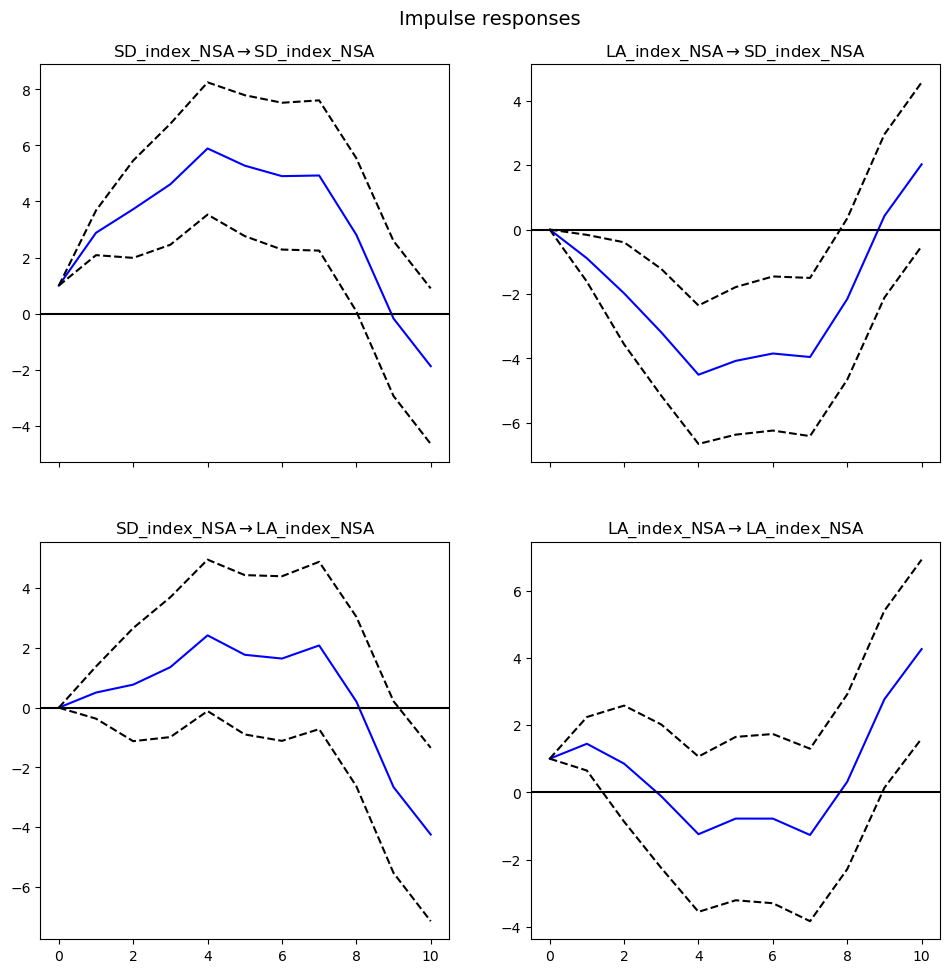

In [14]:
# IRFs 
irfN = varSD.irf(10) 
irfN.plot(orth = False);

IRF plots demonstrate the response of each variable to a one-time shock to the other variable, holding everything else constant. When a shock to the San Diego market happens, LA house prices increase at first but then the effect decays away. This is the opposite to San Diego house prices where an initial shock to the LA house prices decreases San Diego prices but then they adjust and increase.

----

## 4) Problem 7.8

In [51]:
df = pd.read_excel('retail.xlsx', parse_dates=True, skiprows=1)

In [52]:
df = df[['Series ID', 'A3349873A']]
df.columns = ['Date', 'retail']
df = df.set_index('Date')

df.head(2)

retail
Date              
1982-04-01    62.4
1982-05-01    63.1

In [53]:
print(f'First Date: {df.index.min()}')
print(f'Last Date:  {df.index.max()}')

First Date: 1982-04-01 00:00:00
Last Date:  2013-12-01 00:00:00


<Axes: xlabel='Date'>

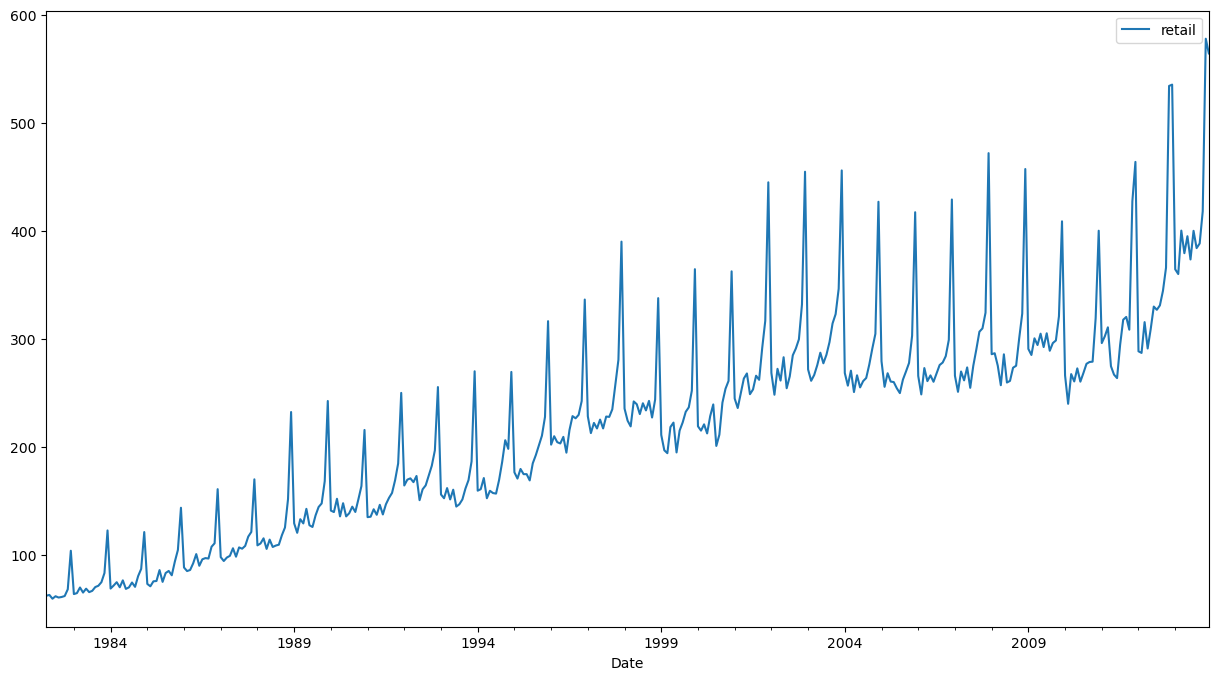

In [54]:
df.plot()

a) A multiplicative seasonality is necessary for this time series because the seasonality effect increases as a function of time.

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose

Text(0.5, 0.98, 'Multiplicative Decomposition')

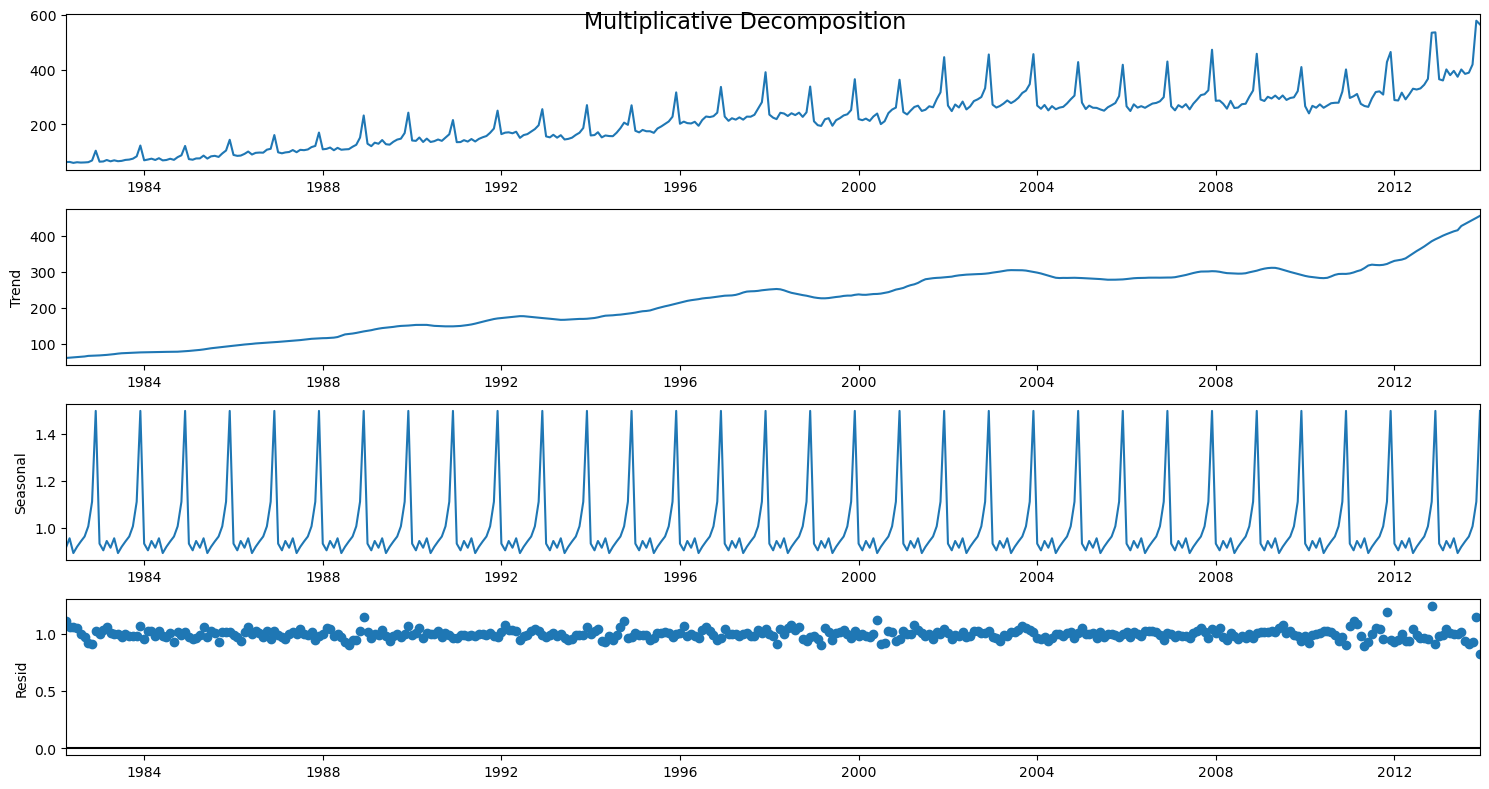

In [56]:
decomposeM = seasonal_decompose(df,model='multiplicative', extrapolate_trend='freq')
plt.rcParams['figure.figsize'] = (15, 8);
#decomposeM.plot();
decomposeM.plot().suptitle('Multiplicative Decomposition', fontsize=16)

In [57]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

b) Fit Holt-Winters

In [58]:
# ets trend-seasonal Combination
hwN_model = HWES(df, seasonal_periods = 12, trend = 'add', seasonal = 'mul') 
hwN_fitted = hwN_model.fit()
print(hwN_fitted.summary())

hwN_fitted.forecast(1)

C:\Users\Josen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                   retail   No. Observations:                  381
Model:             ExponentialSmoothing   SSE                          66762.419
Optimized:                         True   AIC                           2000.283
Trend:                         Additive   BIC                           2063.367
Seasonal:                Multiplicative   AICC                          2002.172
Seasonal Periods:                    12   Date:                 Thu, 25 May 2023
Box-Cox:                          False   Time:                         20:28:30
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5457680                alpha                 True
smoothing_trend          

2014-01-01    392.137856
Freq: MS, dtype: float64

In [59]:
hwN_modelD = HWES(df, 
                 seasonal_periods = 12, 
                 trend = 'add', 
                 seasonal = 'mul',
                damped_trend=True) 
hwN_fittedD = hwN_modelD.fit()
print(hwN_fittedD.summary())

hwN_fittedD.forecast(1)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   retail   No. Observations:                  381
Model:             ExponentialSmoothing   SSE                          66933.229
Optimized:                         True   AIC                           2003.256
Trend:                         Additive   BIC                           2070.284
Seasonal:                Multiplicative   AICC                          2005.361
Seasonal Periods:                    12   Date:                 Thu, 25 May 2023
Box-Cox:                          False   Time:                         20:28:31
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5511019                alpha                 True
smoothing_trend          

C:\Users\Josen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2014-01-01    391.469414
Freq: MS, dtype: float64

c) The model that does not dampen the trend has a slightly better RMSE.

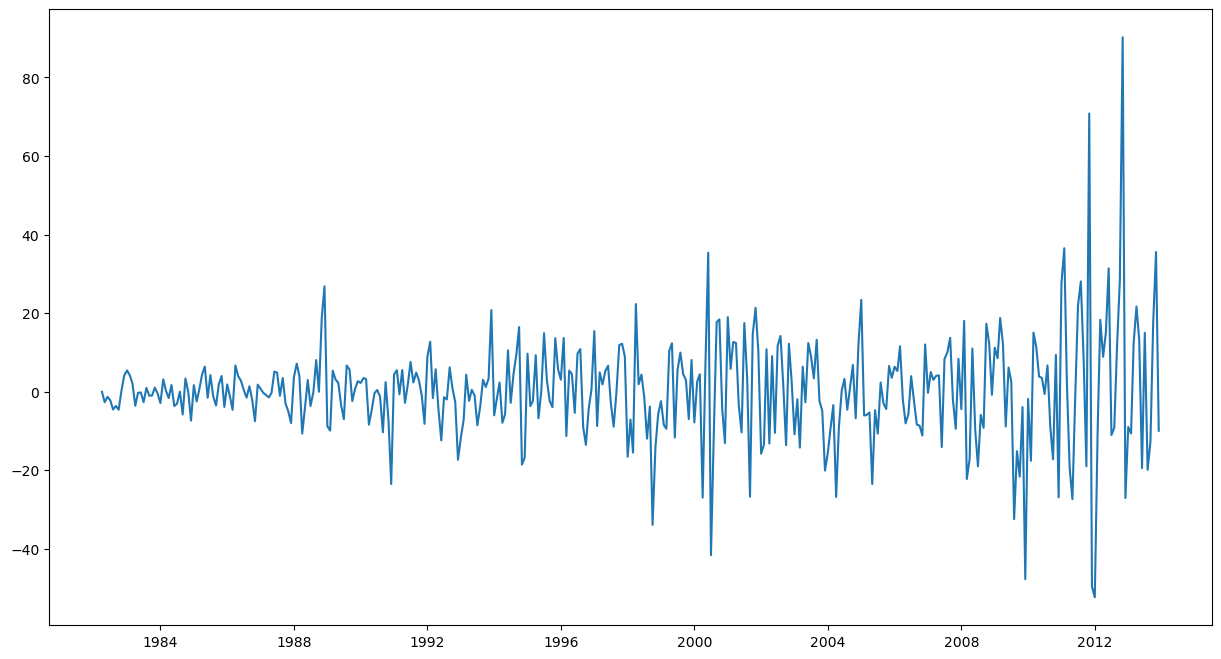

In [60]:
plt.plot(hwN_fitted.resid)

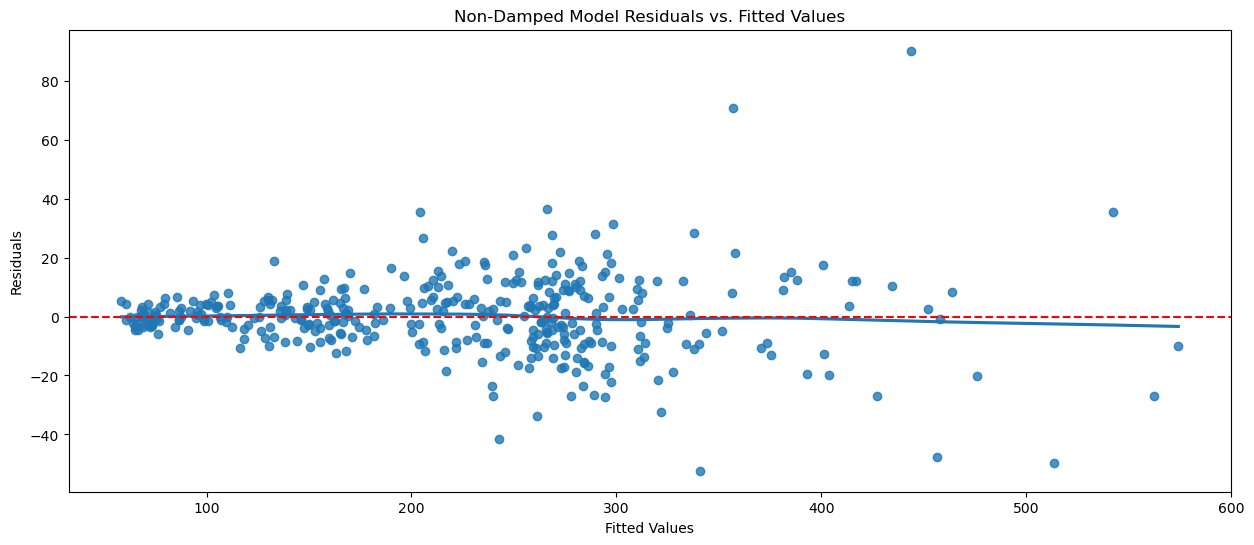

In [61]:
plt.figure(figsize = (15, 6))
plt.title('Non-Damped Model Residuals vs. Fitted Values')
sns.regplot(x = hwN_fitted.fittedvalues, y = hwN_fitted.resid, lowess = True)
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')
plt.axhline(0, linestyle = '--', color = 'red')

The residuals do not look to be white noise.

In [62]:
train = df[df.index.year <= 2010]
test  = df[df.index.year >  2010]

In [63]:
# ets trend-seasonal Combination
hwN_model2 = HWES(train, seasonal_periods = 12, trend = 'add', seasonal = 'mul') 
hwN_fitted2 = hwN_model2.fit()
print(hwN_fitted2.summary())

periods = len(test)
forecast = hwN_fitted2.forecast(periods)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                   retail   No. Observations:                  345
Model:             ExponentialSmoothing   SSE                          25732.929
Optimized:                         True   AIC                           1519.634
Trend:                         Additive   BIC                           1581.131
Seasonal:                Multiplicative   AICC                          1521.732
Seasonal Periods:                    12   Date:                 Thu, 25 May 2023
Box-Cox:                          False   Time:                         20:28:35
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6627396                alpha                 True
smoothing_trend          

C:\Users\Josen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


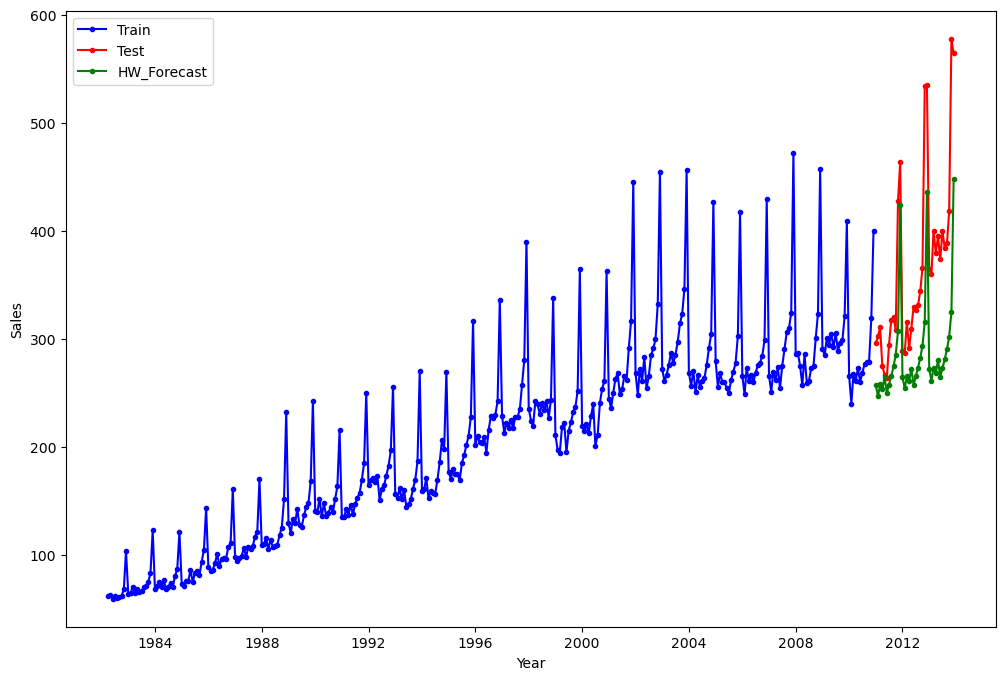

In [64]:
fig = plt.figure(figsize=(12,8))
# fig.suptitle('Retail Sales of Used Cars in the US (1992-2020)')
past, = plt.plot(train.index, train["retail"], 'b.-', label='Train')
future, = plt.plot(test.index, test['retail'], 'r.-', label='Test')
predicted_future, = plt.plot(test.index, forecast, 'g.-', label='HW_Forecast')
plt.legend(handles=[past, future, predicted_future])
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

In [65]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(test, forecast))
rms

93.56564414053547

----

### 5) Problem 7.9

For the same retail data, try an STL decomposition applied to the Box-Cox transformed series, followed by ETS on the seasonally adjusted data. How does that compare with your best previous forecasts on the test set?

In [66]:
#perform box-cox transformation

# import modules
from scipy import stats
from scipy.stats import boxcox
 
# transform training data & save lambda value
bc_df, fitted_lambda = stats.boxcox(df['retail'])
df['bc_retail'] = bc_df

train = df[df.index.year <= 2010]
test  = df[df.index.year >  2010]

Figure(1500x800)


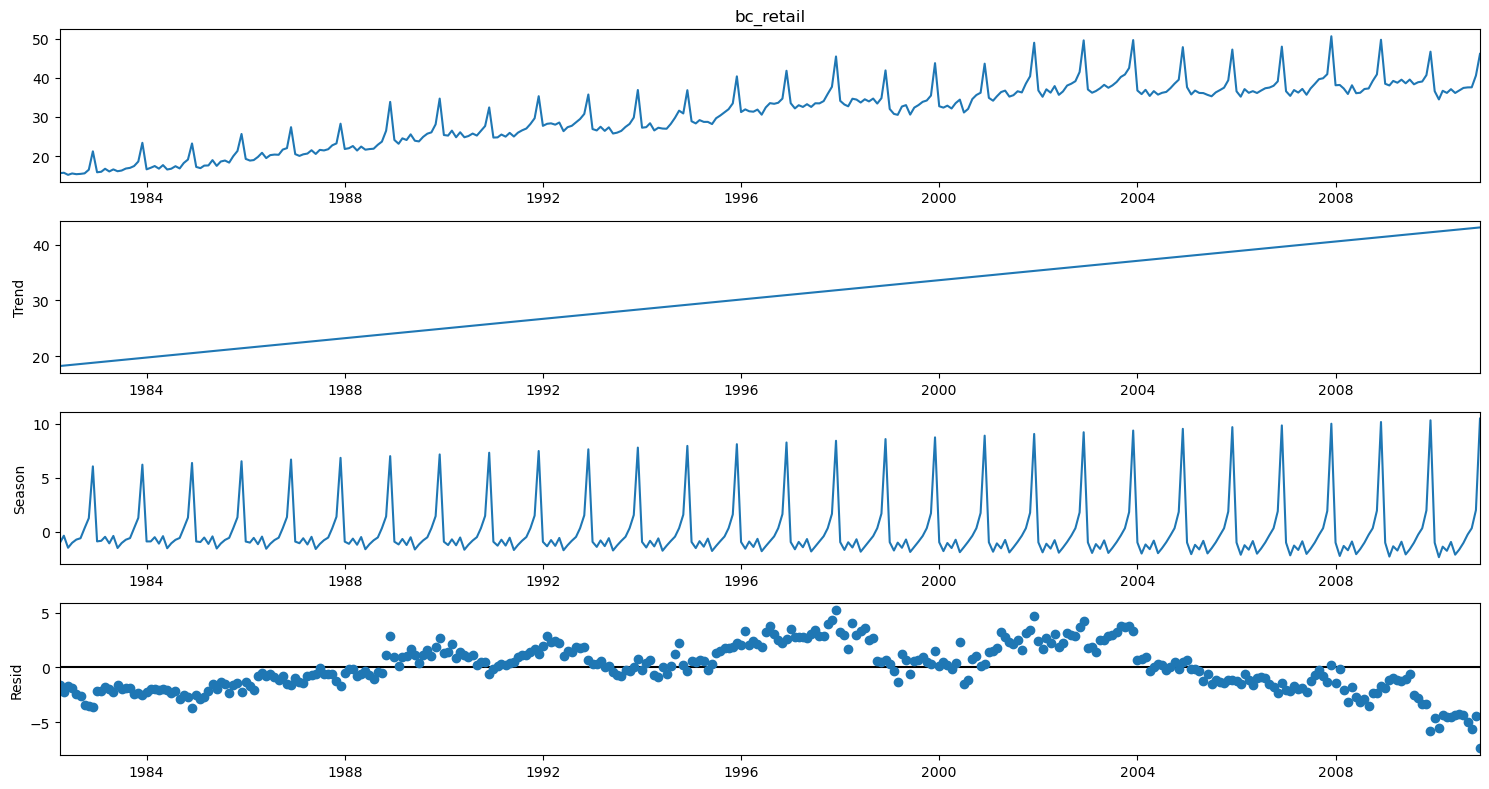

In [67]:
from statsmodels.tsa.seasonal import STL

stl = STL((train['bc_retail']), seasonal = 5001, trend = 5001)
results_stl = stl.fit()

print(results_stl.plot())


<Axes: xlabel='Date'>

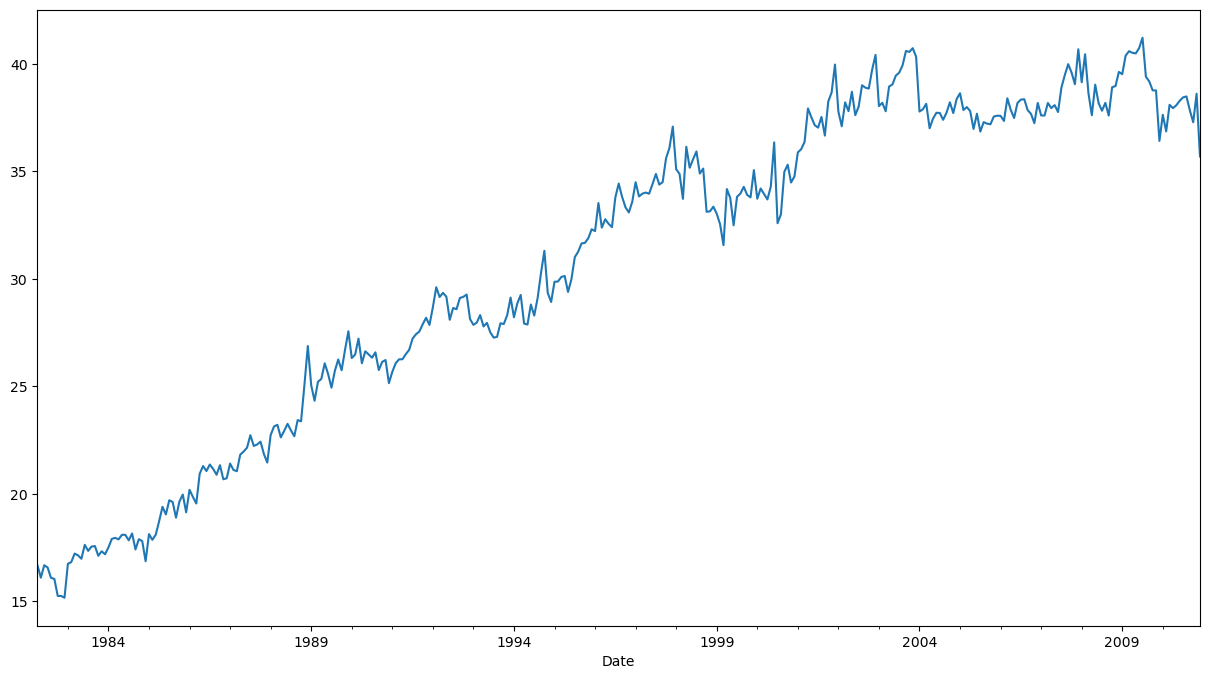

In [68]:
train['seasonl_adj']= train['bc_retail'] - results_stl.seasonal
train['seasonl_adj'].plot()

In [69]:
from statsmodels.tsa.api import ExponentialSmoothing
import statsmodels.api as sm

In [70]:
train.head(3)

retail  bc_retail  seasonl_adj
Date                                      
1982-04-01    62.4  15.608326    16.672011
1982-05-01    63.1  15.714642    16.095135
1982-06-01    59.6  15.177526    16.673928

In [72]:
# Default Holt-Winters Model  
train.index.freq = 'MS'
ets_model =  sm.tsa.statespace.ExponentialSmoothing(train["seasonl_adj"],
                                           trend = True, 
                                           initialization_method = 'heuristic', 
                                           seasonal = 12, 
                                           damped_trend = False).fit()
#Forecast
preds = ets_model.forecast(36)
#RSMY
rms2 = sqrt(mean_squared_error(test['bc_retail'], preds))

It is clear that Holt-Winters is the better method for forecasting because the RMSE is much lower than the ETS forecasting method.

In [74]:
prediction = test.copy()
season_length = 12  
train_arr = np.asarray(train['bc_retail'])
prediction['naive'] = np.nan
for i in range(len(prediction)):
    season_index = i % season_length
    prediction['naive'].iloc[i] = train_arr[len(train_arr) - season_length + season_index]
    
rmse3 = sqrt(mean_squared_error(test['bc_retail'], prediction['naive']))
rmse3

6.80256649414339

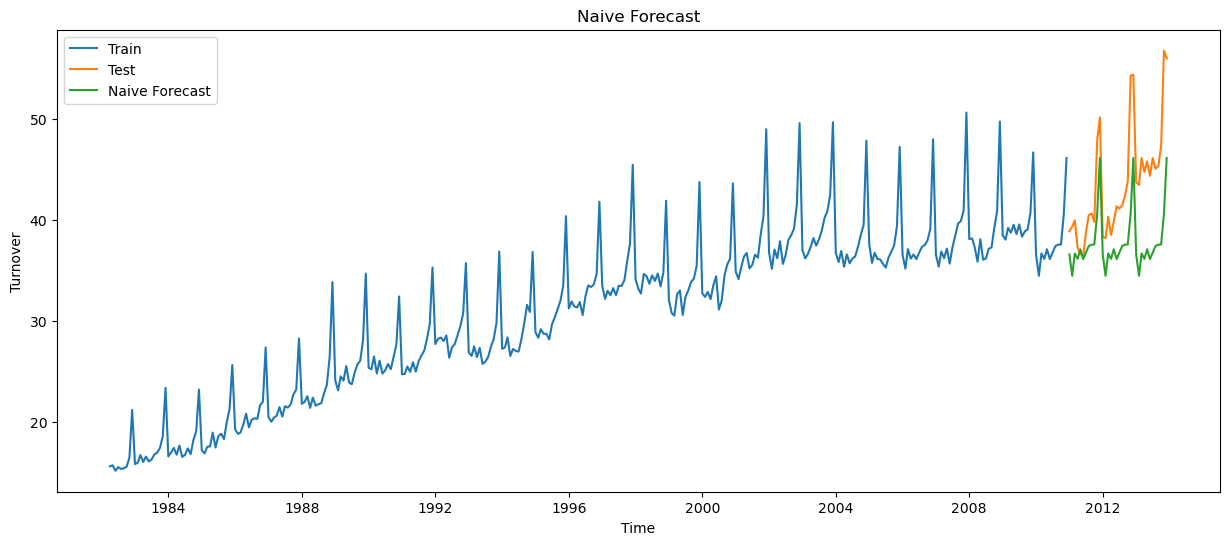

In [75]:
plt.figure(figsize=(15,6))
plt.plot(train.index, train['bc_retail'], label='Train')
plt.plot(test.index, test['bc_retail'], label='Test')
plt.plot(test.index, prediction['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.xlabel('Time')
plt.ylabel('Turnover')
plt.show()

In [77]:
print(f'RMSE using ETS forecasting: {rms2}')
print(f'RMSE using Holt-Winters:  {rms}')
print(f'RMSE using Naive:  {rmse3}')

RMSE using ETS forecasting: 8.127611823203045
RMSE using Holt-Winters:  93.56564414053547
RMSE using Naive:  6.80256649414339


The naive approach is the best model because it has the lower RMSE.

----

### 6) Problem 7.11

For this exercise use data set visitors, the monthly Australian short-term overseas visitors data, May 1985–April 2005.

a) Make a time plot of your data and describe the main features of the series. <br>
b) Split your data into a training set and a test set comprising the last two years of available data. <br> Forecast the test set using Holt-Winters’ multiplicative method. <br>
c) Why is multiplicative seasonality necessary here? <br>
d) Forecast the two-year test set using each of the following methods: <br>
&nbsp;&nbsp;&nbsp;&nbsp;    i. an ETS model; <br>
&nbsp;&nbsp;&nbsp;&nbsp;    ii. an additive ETS model applied to a Box-Cox transformed series; <br>
&nbsp;&nbsp;&nbsp;&nbsp;    iii. a seasonal naïve method; <br>
&nbsp;&nbsp;&nbsp;&nbsp;    iv. an STL decomposition applied to the Box-Cox transformed data followed by an ETS model applied to the seasonally adjusted (transformed) data. <br>
e) Which method gives the best forecasts? Does it pass the residual tests? <br>
f) Compare the same four methods using time series cross-validation with the tsCV() function instead of using a training and test set. Do you come to the same conclusions?

In [78]:
df = pd.read_csv('visitors.csv', parse_dates=True)
df.columns=['Date', 'visitors']
df = df.drop('Date',axis=1)

#gen date index
start_date = '1985-05-01'
end_date = '2005-05-01'
index = pd.date_range(start = start_date, end = end_date, freq = 'M')
df = df.set_index(index)
df.head(3)

visitors
1985-05-31      75.7
1985-06-30      75.4
1985-07-31      83.1

In [79]:
print(f'First Date: {df.index.min()}')
print(f'Last Date:  {df.index.max()}')

First Date: 1985-05-31 00:00:00
Last Date:  2005-04-30 00:00:00


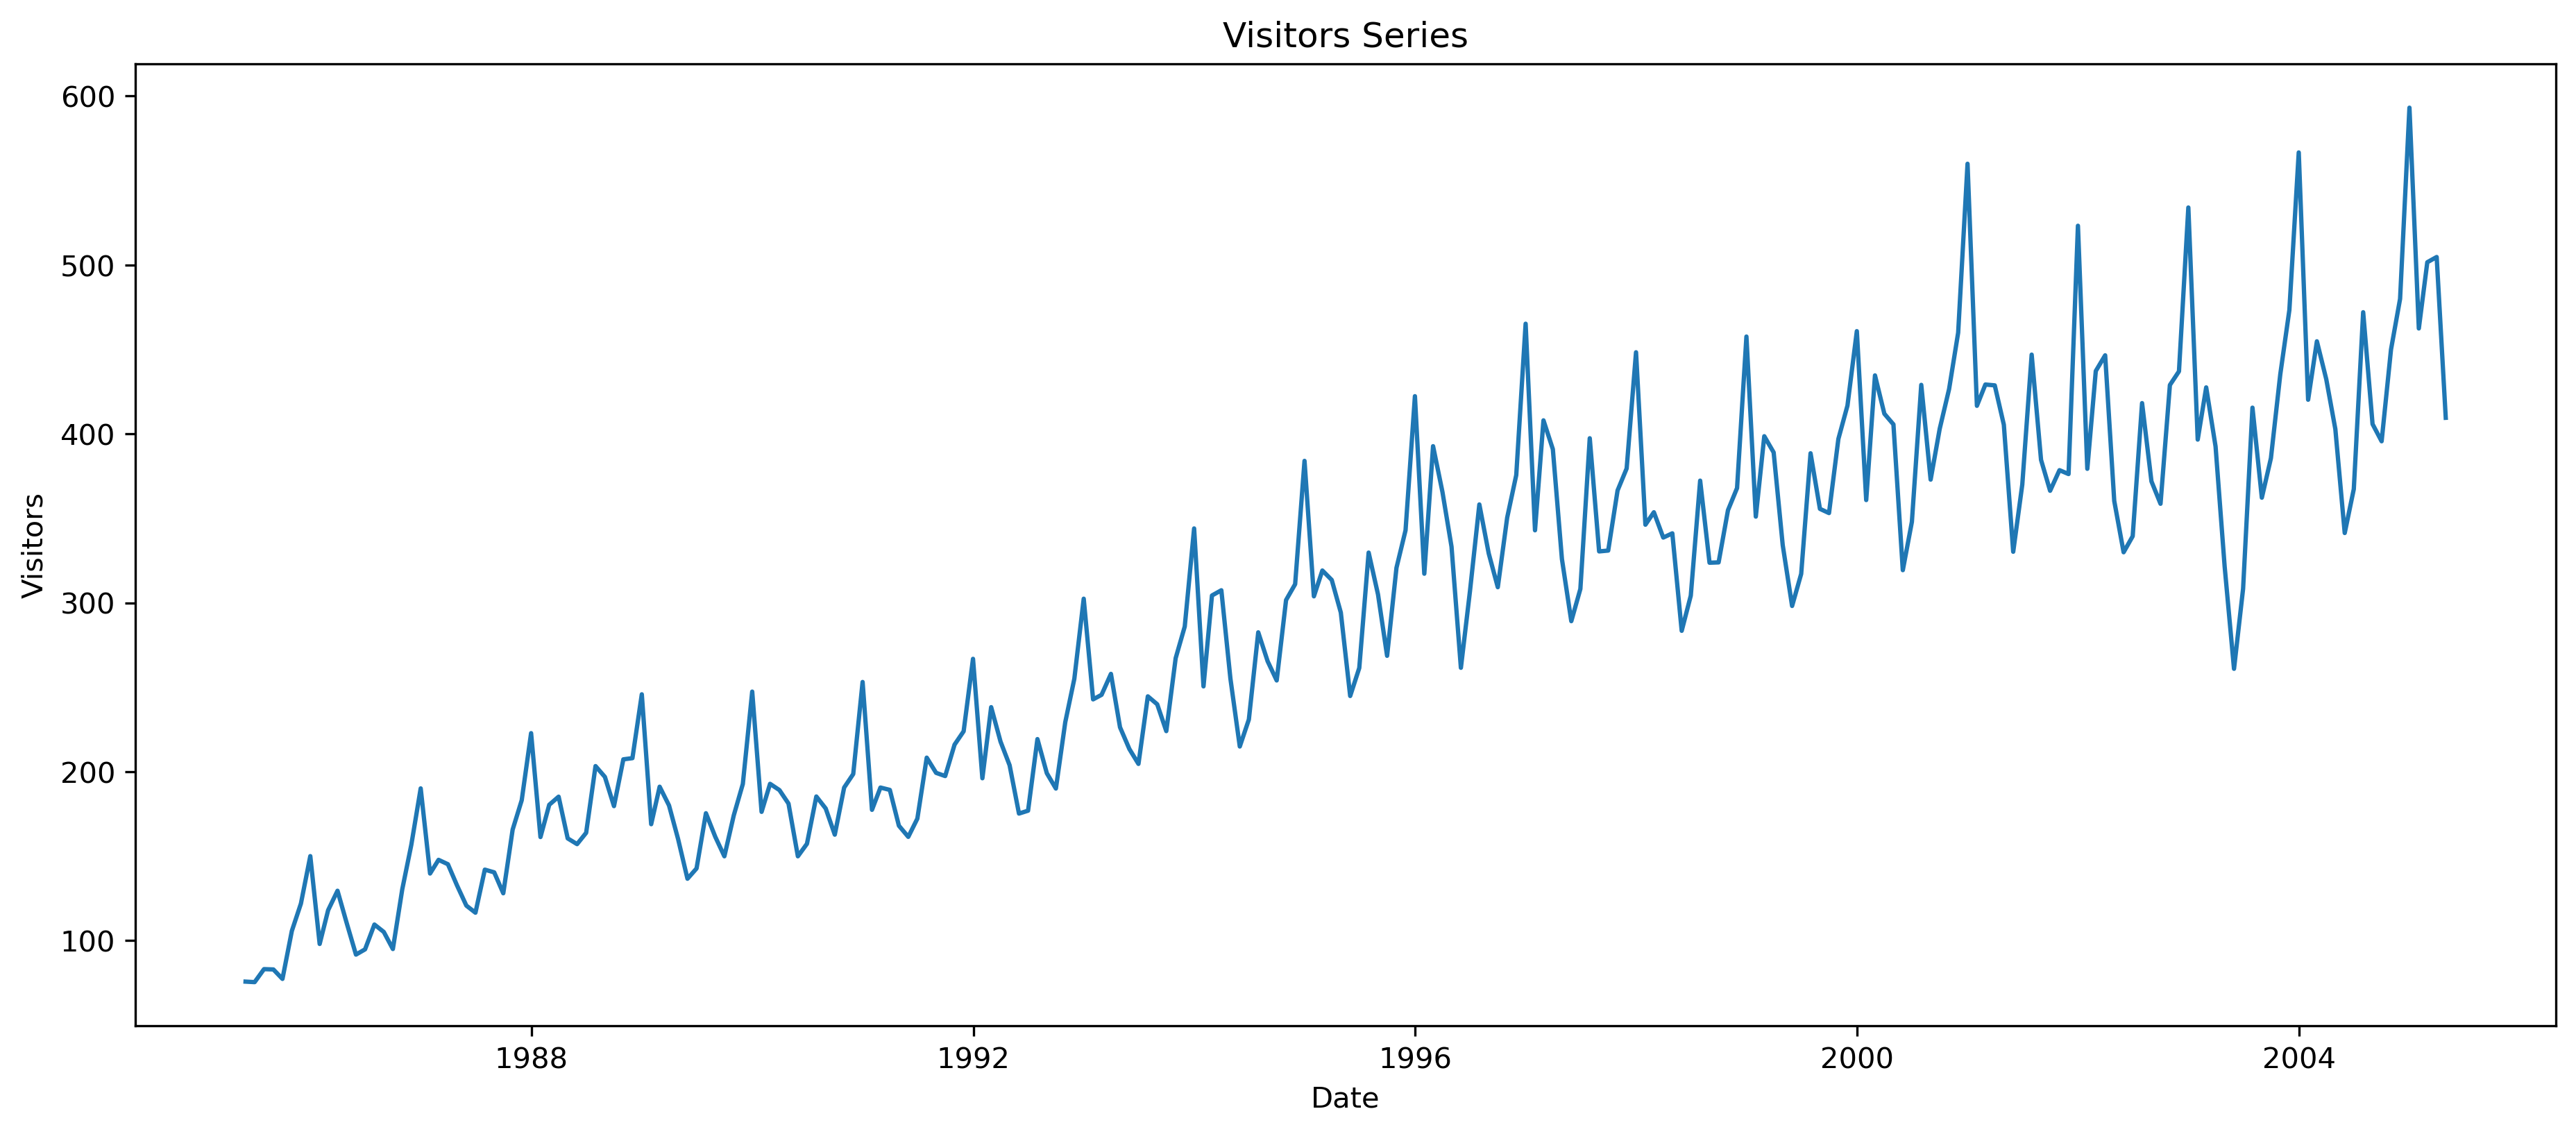

In [80]:
plt.figure(figsize = (15,6), dpi=300)
plt.plot(df, label = 'Visitors')
plt.title('Visitors Series')
plt.xlabel('Date')
plt.ylabel('Visitors')
plt.show();

a) The series demonstrates a linear trend with seasonality. The magnitude of the seasonality seems to be increasing.

In [81]:
# b) split into train/test (test should be two years)
train = df[:-24]
test  = df[-24:]

In [82]:
hw = HWES(train, seasonal_periods = 12, trend = 'mul', seasonal = 'mul')
hw_fitted = hw.fit()
print(hw_fitted.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 visitors   No. Observations:                  216
Model:             ExponentialSmoothing   SSE                          41845.601
Optimized:                         True   AIC                           1169.556
Trend:                   Multiplicative   BIC                           1223.561
Seasonal:                Multiplicative   AICC                          1173.028
Seasonal Periods:                    12   Date:                 Thu, 25 May 2023
Box-Cox:                          False   Time:                         20:29:59
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6027144                alpha                 True
smoothing_trend          

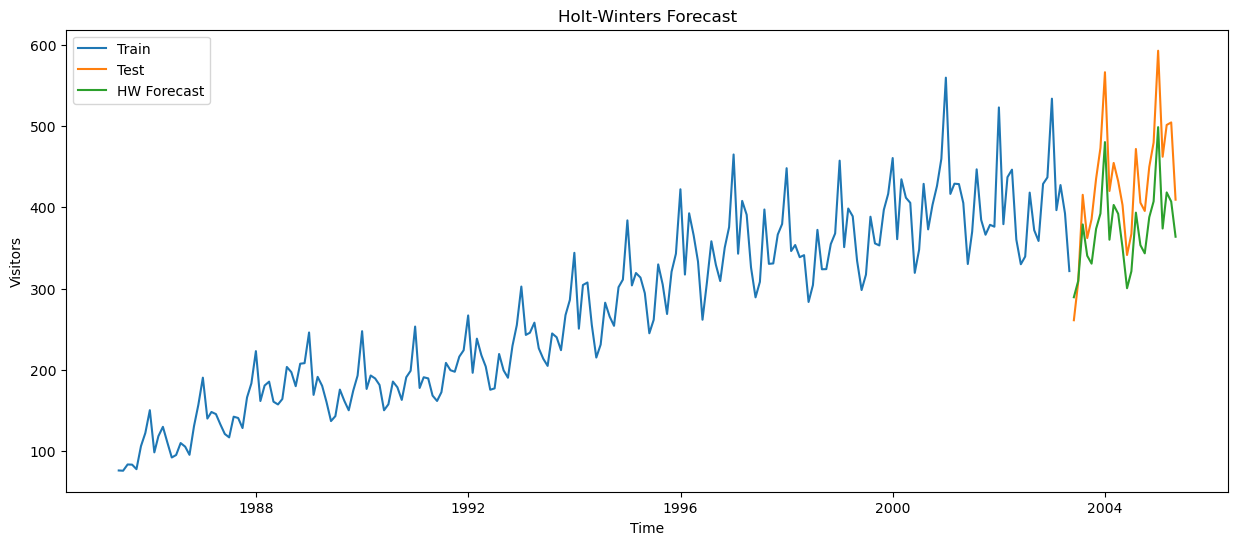

In [83]:
fc = hw_fitted.forecast(steps = 24)

plt.figure(figsize = (15,6))
plt.plot(train.index, train['visitors'], label='Train')
plt.plot(test.index, test['visitors'], label='Test')
plt.plot(fc.index, fc, label='HW Forecast')
plt.legend(loc='best')
plt.title("Holt-Winters Forecast")
plt.xlabel('Time')
plt.ylabel('Visitors')
plt.show()

Seasonlity must be modeled as multiplicative because the variance is increasing as a function of time.

In [84]:
### ETS
ets_vis = sm.tsa.statespace.ExponentialSmoothing(train.visitors,
                                           trend=True, 
                                           initialization_method= 'heuristic', 
                                           seasonal=12, 
                                           damped_trend=False).fit()

fc_per = len(test)
fc_etsVis = ets_vis.forecast(fc_per) 

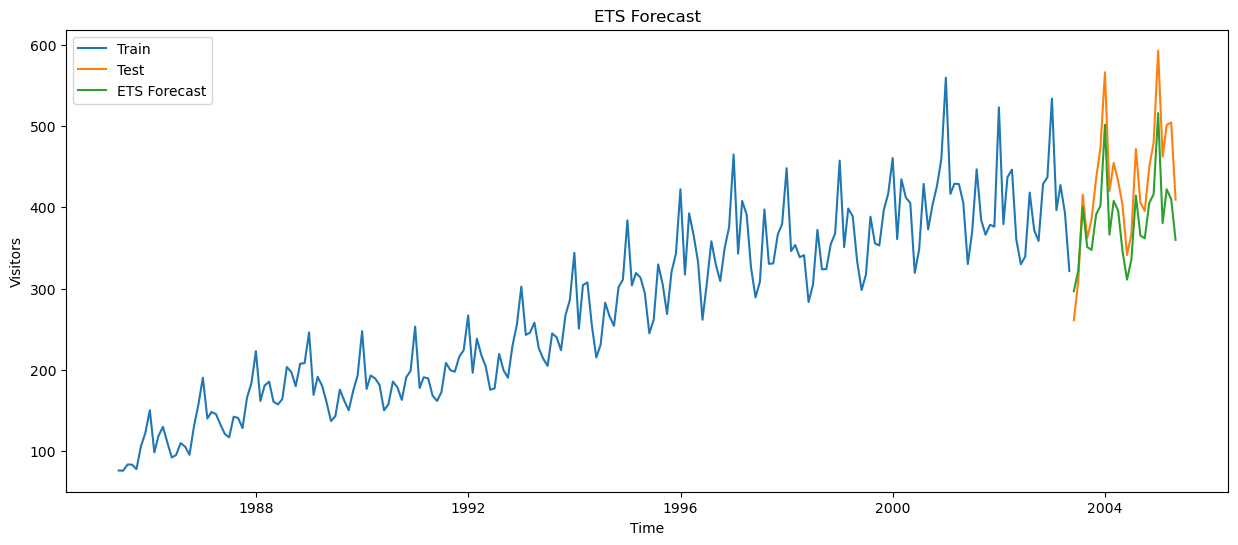

In [85]:
plt.figure(figsize = (15,6))
plt.plot(train.index, train['visitors'], label='Train')
plt.plot(test.index, test['visitors'], label='Test')
plt.plot(fc_etsVis.index, fc_etsVis, label='ETS Forecast')
plt.legend(loc='best')
plt.title("ETS Forecast")
plt.xlabel('Time')
plt.ylabel('Visitors')
plt.show()

In [86]:
# ETS model with box-cox transformation
df2 = df.copy()
bc_vis, lambda_ = stats.boxcox(df2['visitors'])
print(lambda_)
df2['bc_visitors'] = bc_vis
train2 = df2[:-24]
test2 = df2[-24:]

0.6870550348415251


In [87]:
train2.index.freq = pd.infer_freq(train2.index)
test2.index.freq = pd.infer_freq(test2.index)
ets_bcvis = sm.tsa.statespace.ExponentialSmoothing(train2['bc_visitors'],
                                           trend=True, 
                                           initialization_method= 'heuristic', 
                                           seasonal=12, 
                                           damped_trend=False).fit()
fc_per2 = len(test2)
fc_bcetsVis = ets_bcvis.forecast(fc_per2)

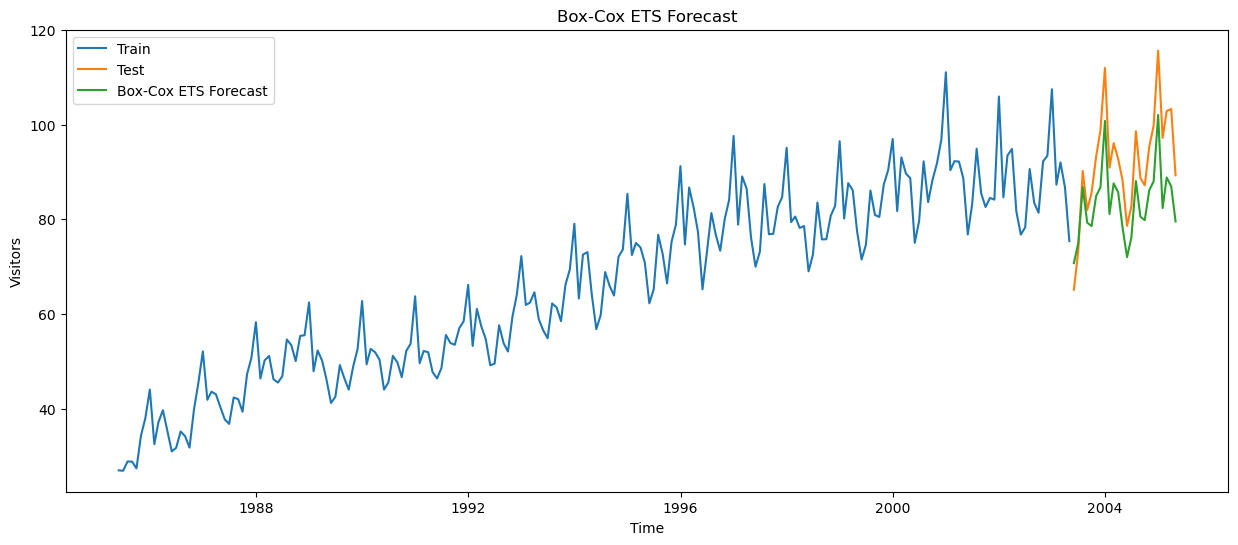

In [88]:
plt.figure(figsize = (15,6))
plt.plot(train2.index, train2['bc_visitors'], label='Train')
plt.plot(test2.index, test2['bc_visitors'], label='Test')
plt.plot(fc_bcetsVis.index, fc_bcetsVis, label='Box-Cox ETS Forecast')
plt.legend(loc='best')
plt.title("Box-Cox ETS Forecast")
plt.xlabel('Time')
plt.ylabel('Visitors')
plt.show()

In [89]:
### Seasonal Naive
test3 = test.copy()
train3 = train.copy()
prediction = test3.copy()
season_length = 12  
train_arr = np.asarray(train3['visitors'])
prediction['naive'] = np.nan
for i in range(len(prediction)):
    season_index = i % season_length
    prediction['naive'].iloc[i] = train_arr[len(train_arr) - season_length + season_index]

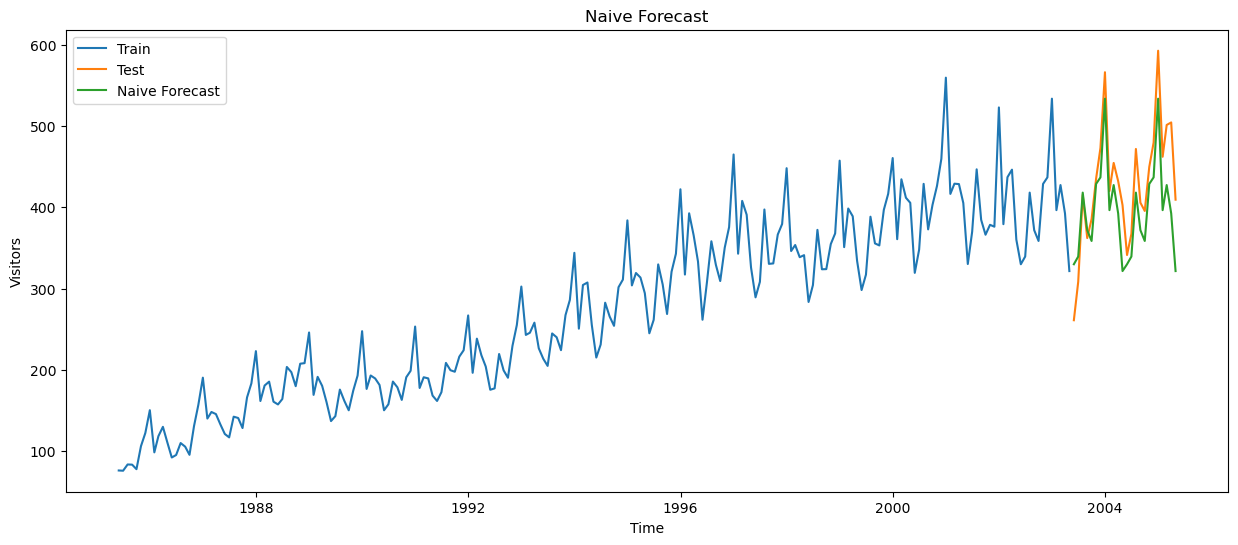

In [90]:
plt.figure(figsize = (15,6))
plt.plot(train3.index, train3['visitors'], label='Train')
plt.plot(test3.index, test3['visitors'], label='Test')
plt.plot(prediction.index, prediction.naive, label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.xlabel('Time')
plt.ylabel('Visitors')
plt.show()

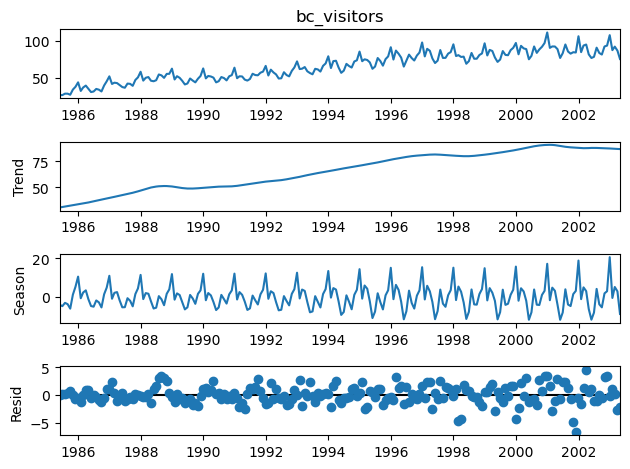

In [46]:
### STL decomposition applied to the Box-Cox transformed data and ETS
train4 = train2.copy()
test4 = test2.copy()
stl_vis = STL(train4['bc_visitors']).fit()
fig = stl_vis.plot()

In [47]:
# adfuller test 
adf = adfuller(train4['bc_visitors'])[1]
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary.")

#take first difference to make series stationary
train4 = train4.diff(1).dropna()
adf = adfuller(train4["bc_visitors"])[1]
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary.")

p value:0.3592959349775249 , Series is Non-Stationary.
p value:0.0005981662960780276 , Series is Stationary


In [48]:
#ad fuller test
adf = adfuller(test4['bc_visitors'])[1]
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary.")

test4 = test4.diff(1).dropna()
adf = adfuller(test4["bc_visitors"])[1]
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary.")

p value:0.009536928015393766 , Series is Stationary
p value:4.0967218775020907e-07 , Series is Stationary


In [49]:
train4.index.freq = pd.infer_freq(train4.index)
test4.index.freq = pd.infer_freq(test4.index)
ets_visit_bc = sm.tsa.statespace.ExponentialSmoothing(train4['bc_visitors'],
                                           trend=True, 
                                           initialization_method= 'heuristic', 
                                           seasonal=12, 
                                           damped_trend=False).fit()
fc_visit_bc = ets_visit_bc.forecast(len(test4)) 

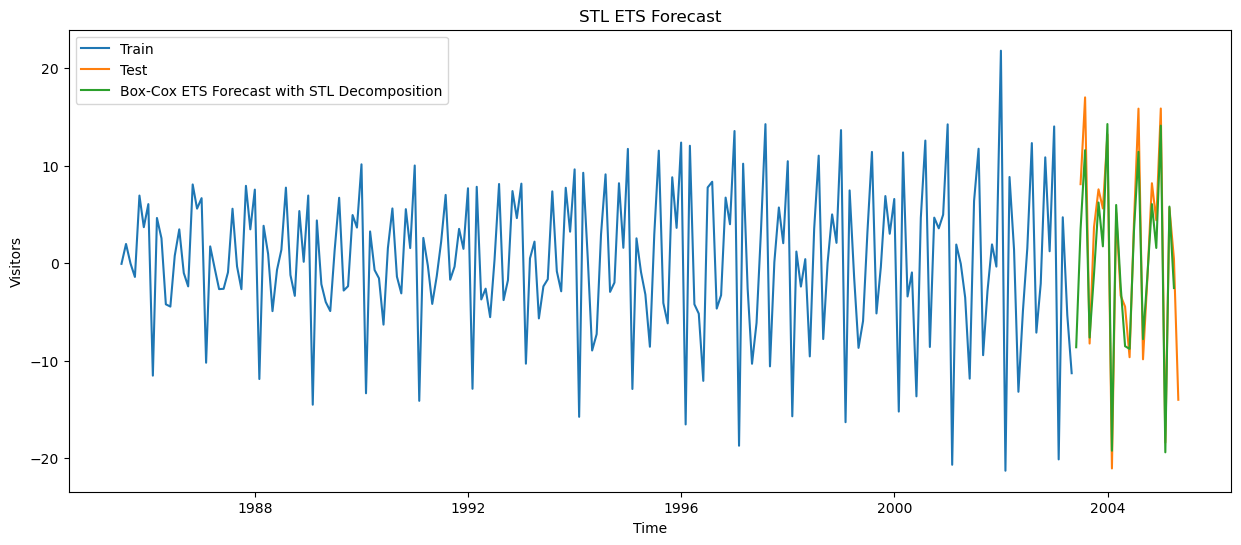

In [50]:
plt.figure(figsize = (15,6))
plt.plot(train4.index, train4['bc_visitors'], label='Train')
plt.plot(test4.index, test4['bc_visitors'], label='Test')
plt.plot(fc_visit_bc.index, fc_visit_bc, label='Box-Cox ETS Forecast with STL Decomposition')
plt.legend(loc='best')
plt.title("STL ETS Forecast")
plt.xlabel('Time')
plt.ylabel('Visitors')
plt.show()

In [51]:
### Comparison
HW = np.sqrt(mean_squared_error(test.visitors, fc))
ETS = np.sqrt(mean_squared_error(test.visitors, fc_etsVis))
BCETS = np.sqrt(mean_squared_error(test2.bc_visitors, fc_bcetsVis))
NAIVE = np.sqrt(mean_squared_error(test3.visitors, prediction['naive']))
STL = np.sqrt(mean_squared_error(test4.bc_visitors, fc_visit_bc))

print('RMSE for Holt-Winters:', HW)
print('RMSE for ETS:', ETS)
print('RMSE for Box-Cox Transformed:', BCETS)
print('RMSE for Naive:', NAIVE)
print('RMSE for STL ETS:', STL)

RMSE for Holt-Winters: 62.525347896990446
RMSE for ETS: 53.402732999853164
RMSE for Box-Cox Transformed: 9.706030109114213
RMSE for Naive: 50.30097331728947
RMSE for STL ETS: 16.26203226908095


In [52]:
# The box-cox transformed ETS model had the best overall performance

In [53]:
resid_best = ets_bcvis.resid

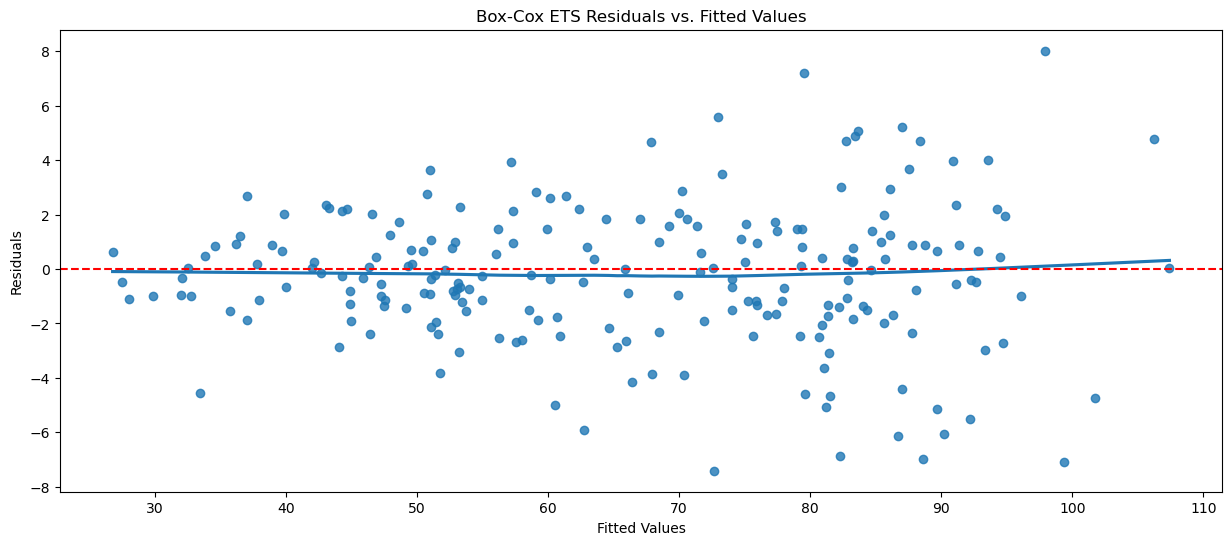

In [54]:
plt.figure(figsize = (15, 6))
plt.title('Box-Cox ETS Residuals vs. Fitted Values')
sns.regplot(x = ets_bcvis.fittedvalues, y = resid_best, lowess = True)
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')
plt.axhline(0, linestyle = '--', color = 'red')

In [55]:
print(f'Average Residuals: {resid_best.mean()}')
print(f'Residual Variance: {np.var(resid_best)}')

Average Residuals: -0.2499440546244093
Residual Variance: 6.507869956245494


Text(0, 0.5, 'ACF')

<Figure size 1500x600 with 0 Axes>

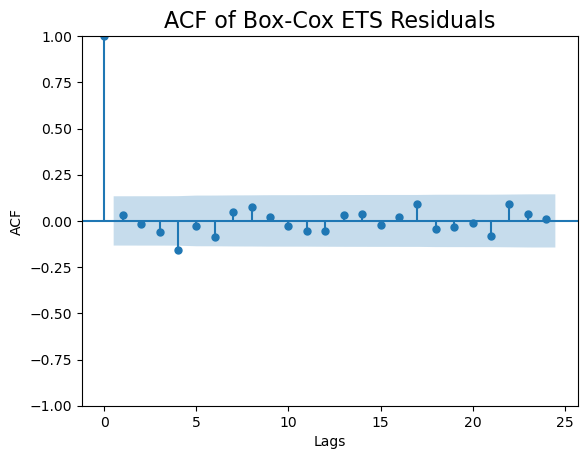

In [56]:
plt.figure(figsize=(15,6))
plot_acf(resid_best, label = "Box-Cox ETS Residuals")
plt.title('ACF of Box-Cox ETS Residuals', fontsize=16)
plt.xlabel('Lags')
plt.ylabel('ACF')

The residuals resemeble white noise since they are within the bands.

---

### 7) Problem 8.13

In [57]:
gas = pd.read_csv('aus_production.csv')
gas = gas[['Quarter','Gas']]
gas['Quarter'] = gas['Quarter'].astype(str)
gas['Quarter'] = gas['Quarter'].str.replace(' ', '-',)
gas['Quarter'] = pd.to_datetime(gas['Quarter'])
gas = gas.set_index('Quarter')
gas.head(2)

Gas
Quarter        
1956-01-01    5
1956-04-01    6

In [58]:
gas.describe().T

count       mean        std  min    25%    50%     75%    max
Gas  218.0  99.206422  75.985377  5.0  11.25  105.0  163.75  252.0

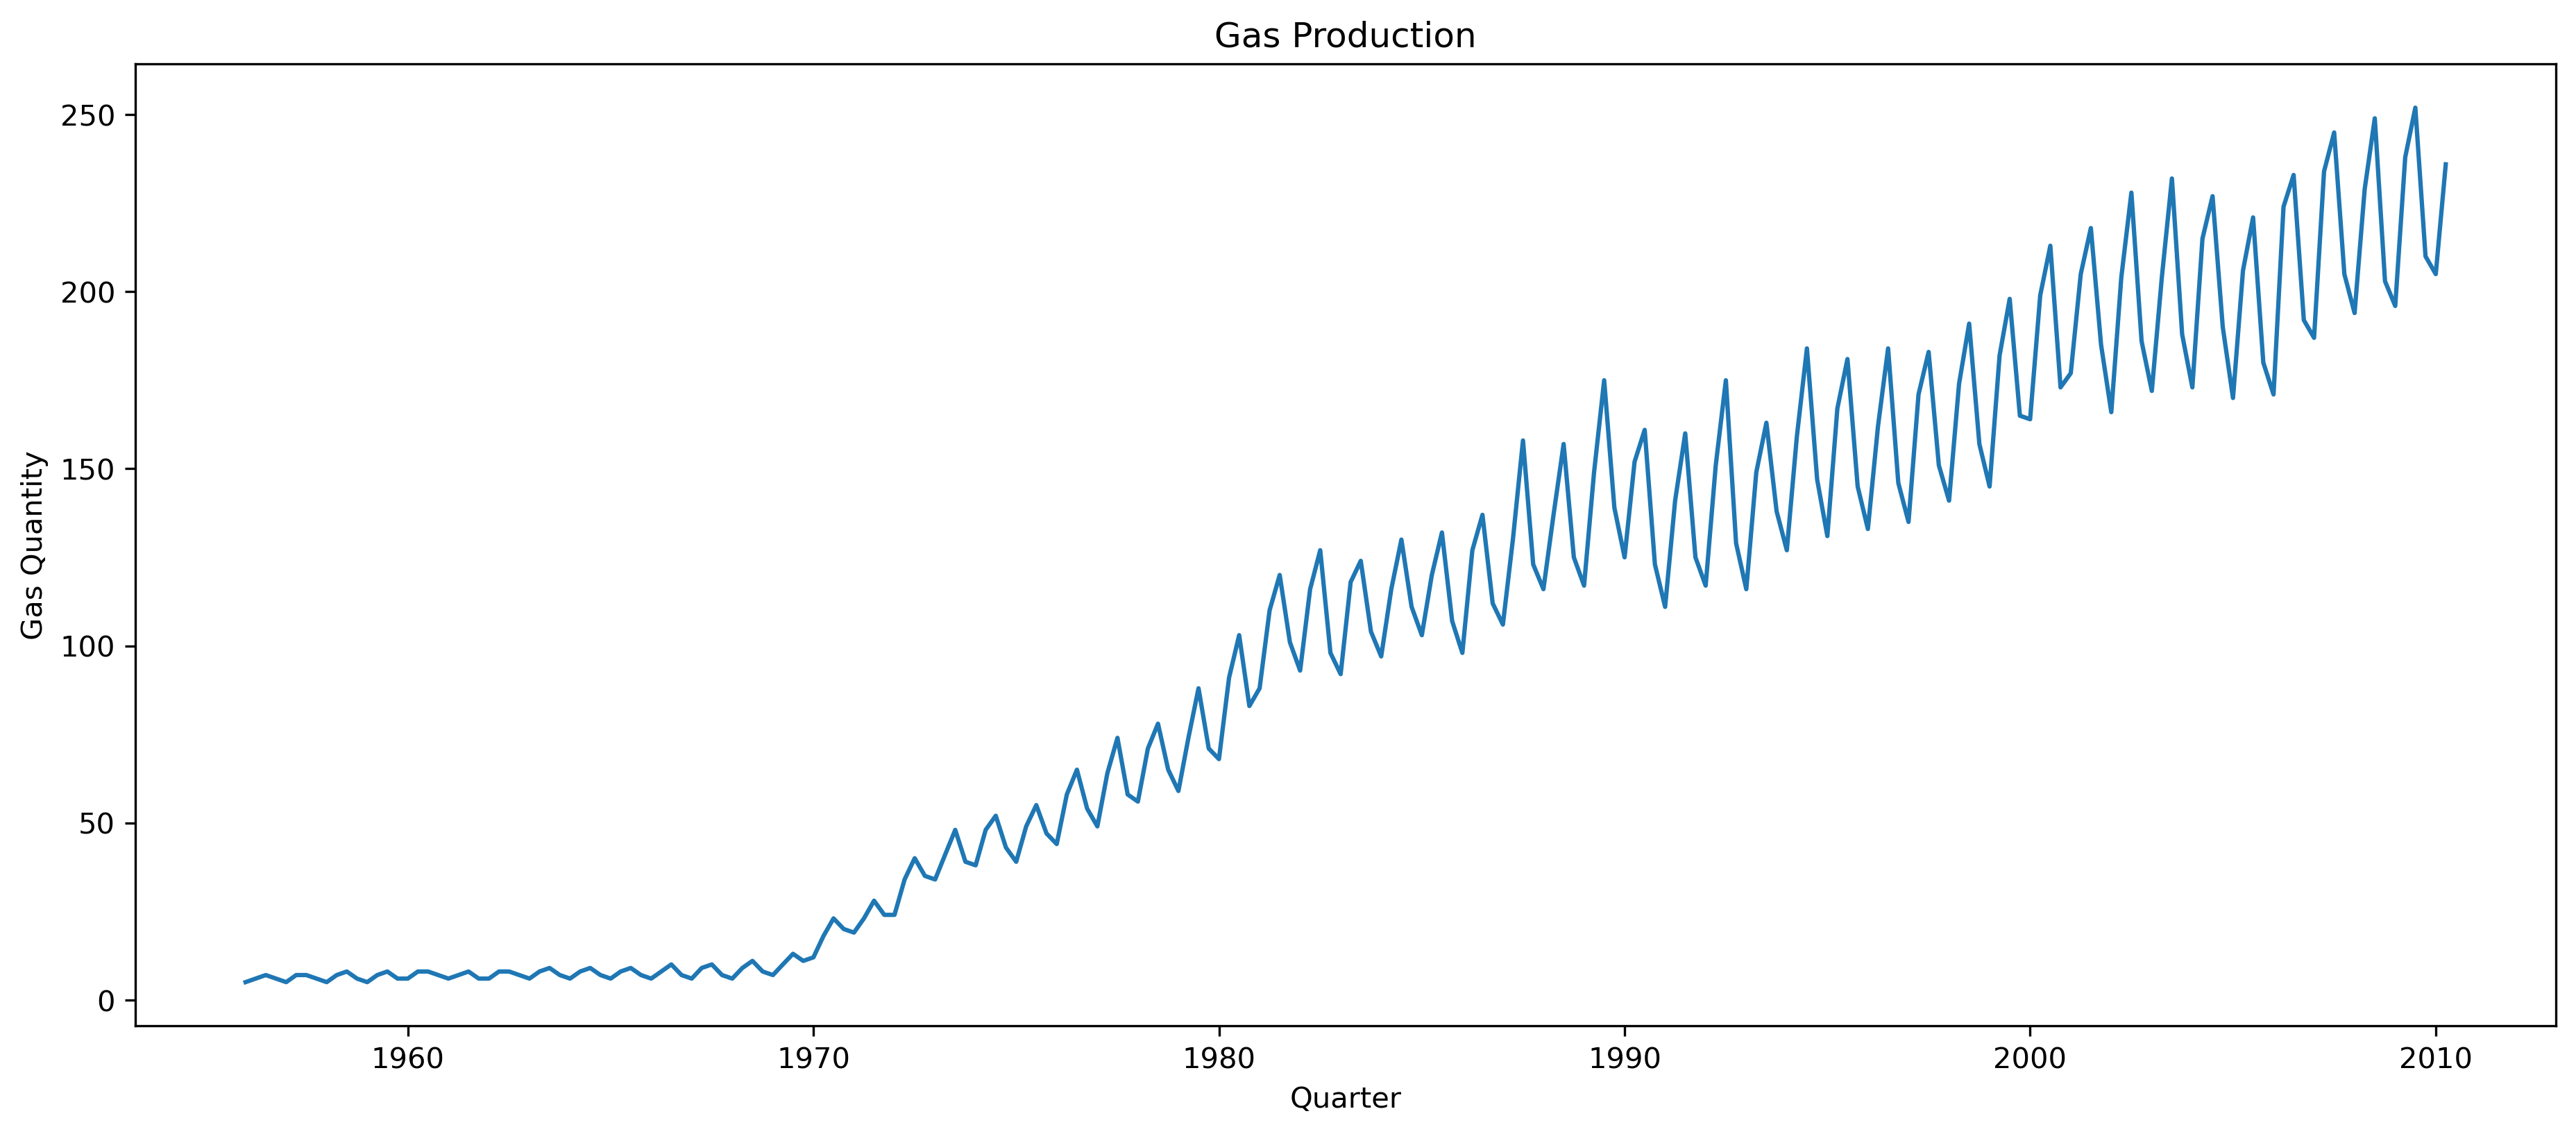

In [59]:
plt.figure(figsize=(15,6), dpi=300)
plt.plot(gas)
plt.title('Gas Production')
plt.xlabel('Quarter')
plt.ylabel('Gas Quantity')
plt.show()

In [60]:
#  check box-cox transformation
bc_gas, lambda_ = stats.boxcox(gas['Gas'])
print(lambda_)

gas['bc_gas'] = bc_gas

0.4374315279941498


The lambda score of 0.44 suggests that a transformation may be needed

In [61]:
### Test Stationarity
adf = adfuller(gas.bc_gas)[1]
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

#take first difference
de_trended = gas.bc_gas.diff(1).dropna()
adf2 = adfuller(de_trended)[1]
print(f"p value:{adf2}", ", Series is Stationary" if adf2 <0.05 else ", Series is Non-Stationary")

p value:0.751234030326283 , Series is Non-Stationary
p value:0.0169075537842648 , Series is Stationary


Text(0, 0.5, 'ACF')

<Figure size 1500x600 with 0 Axes>

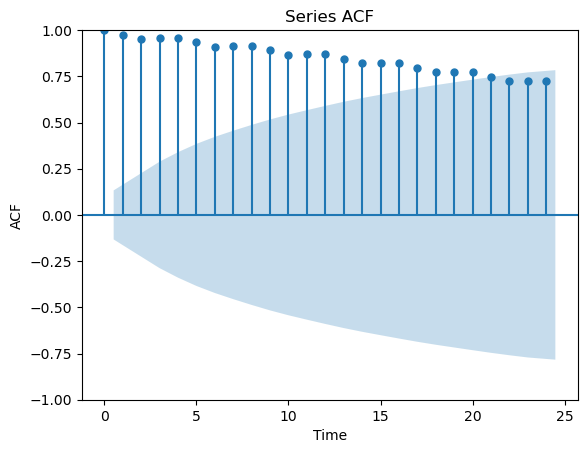

In [62]:
# Plot ACF
plt.figure(figsize=(15,6))
plot_acf(gas.bc_gas)
plt.title('Series ACF')
plt.xlabel('Time')
plt.ylabel('ACF')

Text(0, 0.5, 'PACF')

<Figure size 1500x600 with 0 Axes>

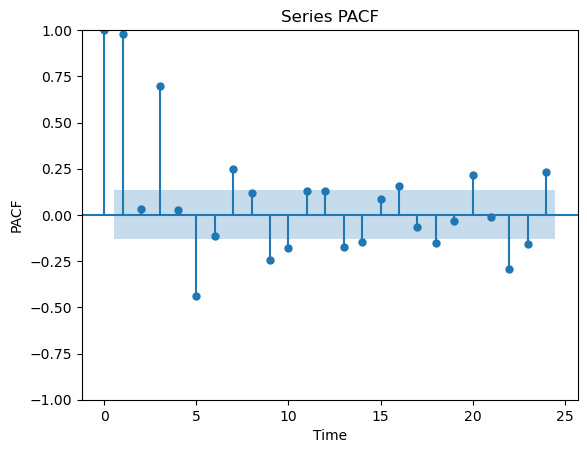

In [63]:
plt.figure(figsize=(15,6))
plot_pacf(gas.bc_gas)
plt.title('Series PACF')
plt.xlabel('Time')
plt.ylabel('PACF')

The PACF plot suggests an ARIMA model with order 1 will be adequate.

In [64]:
from statsmodels.tsa.arima.model import ARIMA

In [65]:
model1 = ARIMA(gas.bc_gas, order = (1,1,0)).fit()
model1.summary()

C:\Users\Josen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Josen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Josen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 bc_gas   No. Observations:                  218
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -349.625
Date:                Thu, 25 May 2023   AIC                            703.250
Time:                        18:18:47   BIC                            710.009
Sample:                    01-01-1956   HQIC                           705.980
                         - 04-01-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0043      0.105     -0.041      0.967      -0.211       0.202
sigma2         1.4688      0.239      6.141      0.000       1.000       1.938
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 5.99
Prob(Q):                              0.89   Prob(JB):                         0.05
Heteroskedasticity (H):               6.27   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
model2 = ARIMA(gas.bc_gas, order = (0,1,0), seasonal_order=(1, 1, 0, 4)).fit()
model2.summary()

C:\Users\Josen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Josen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Josen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                          bc_gas   No. Observations:                  218
Model:             ARIMA(0, 1, 0)x(1, 1, 0, 4)   Log Likelihood                 -50.544
Date:                         Thu, 25 May 2023   AIC                            105.089
Time:                                 18:18:47   BIC                            111.811
Sample:                             01-01-1956   HQIC                           107.805
                                  - 04-01-2010                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L4       -0.5364      0.058     -9.259      0.000      -0.650      -0.423
sigma2         0.0935      0.007     12.814      0.000       0.079       0.108
===================================================================================
Ljung-Box (L1) (Q):                   5.84   Jarque-Bera (JB):                12.66
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               2.61   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [67]:
print(f"Model 1 order=(0,1,0) AIC Score:                 {model1.aic}")
print(f"Model 2 order=(0,1,0) season(1,1,0,4) AIC Score: {model2.aic}")

Model 1 order=(0,1,0) AIC Score:                 703.2496993486592
Model 2 order=(0,1,0) season(1,1,0,4) AIC Score: 105.08861595476621


We will select the second ARIMA model as the AIC score is much lower than the first model.

In [68]:
resid2 = model2.resid

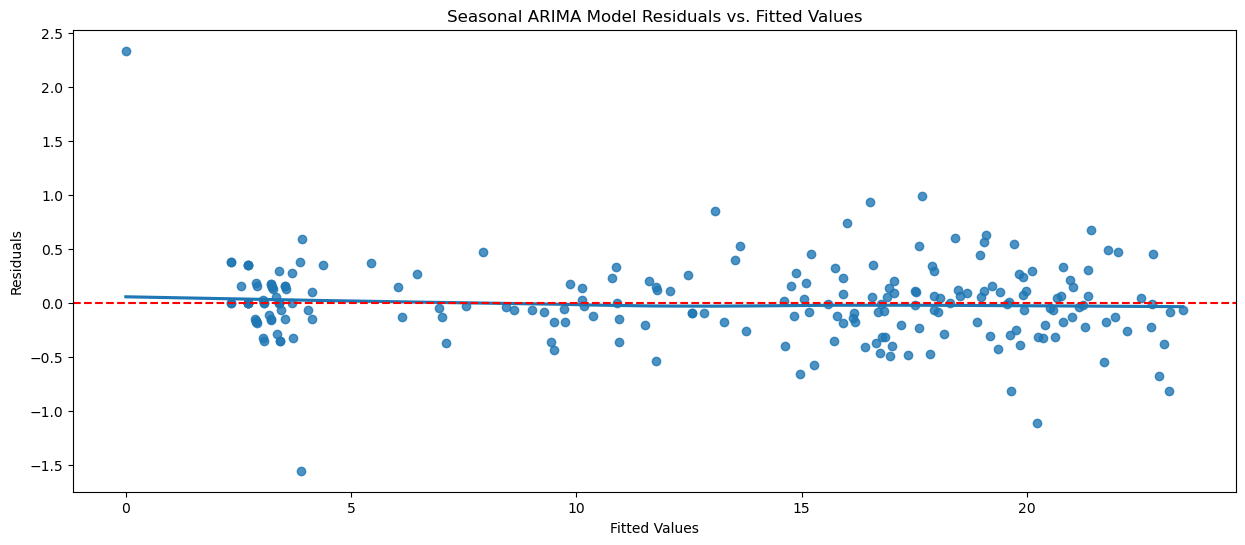

In [69]:
plt.figure(figsize = (15, 6))
plt.title('Seasonal ARIMA Model Residuals vs. Fitted Values')
sns.regplot(x = model2.fittedvalues, y = resid2, lowess = True)
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')
plt.axhline(0, linestyle = '--', color = 'red')

Text(0, 0.5, 'ACF')

<Figure size 1500x600 with 0 Axes>

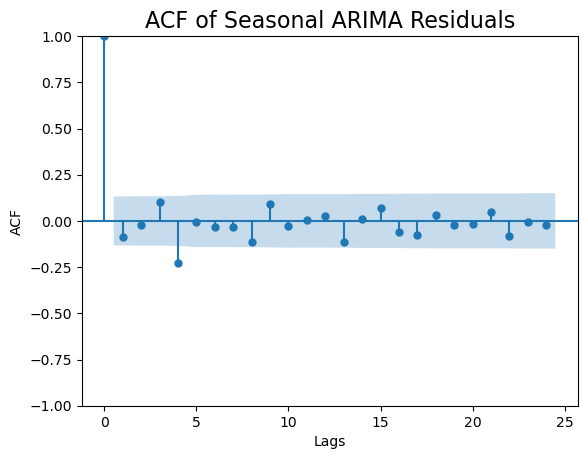

In [70]:
plt.figure(figsize=(15,6))
plot_acf(resid2, label = "Seasonal Arima Residuals")
plt.title('ACF of Seasonal ARIMA Residuals', fontsize=16)
plt.xlabel('Lags')
plt.ylabel('ACF')

The ACF looks pretty good. There is one statistically significant spike at lag 4 but the rest of the spikes are near 0 and not statistically significant. The residuals can be said to be exhibiting white noise behavior

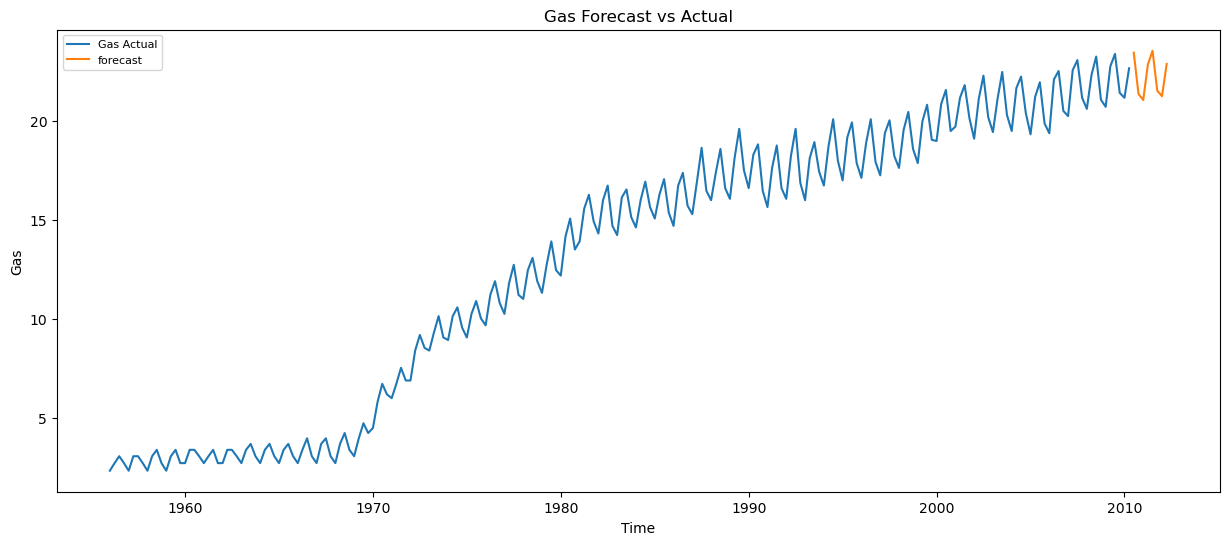

In [71]:
fc = model2.forecast(9, alpha=0.05)
fc_series2 = pd.Series(fc, index=model2.get_forecast(8).conf_int().index)

plt.figure(figsize=(15,6), dpi=100)
plt.plot(gas.bc_gas, label='Gas Actual')
plt.plot(fc_series2, label='forecast')

plt.title('Gas Forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('Time')
plt.ylabel('Gas')
plt.show()

In [72]:
# ETS
gas.index.freq = pd.infer_freq(gas.index)

In [73]:
ets_gas = sm.tsa.statespace.ExponentialSmoothing(gas.bc_gas,
                                           trend=True, 
                                           initialization_method= 'heuristic', 
                                           seasonal=4, 
                                           damped_trend=False).fit()

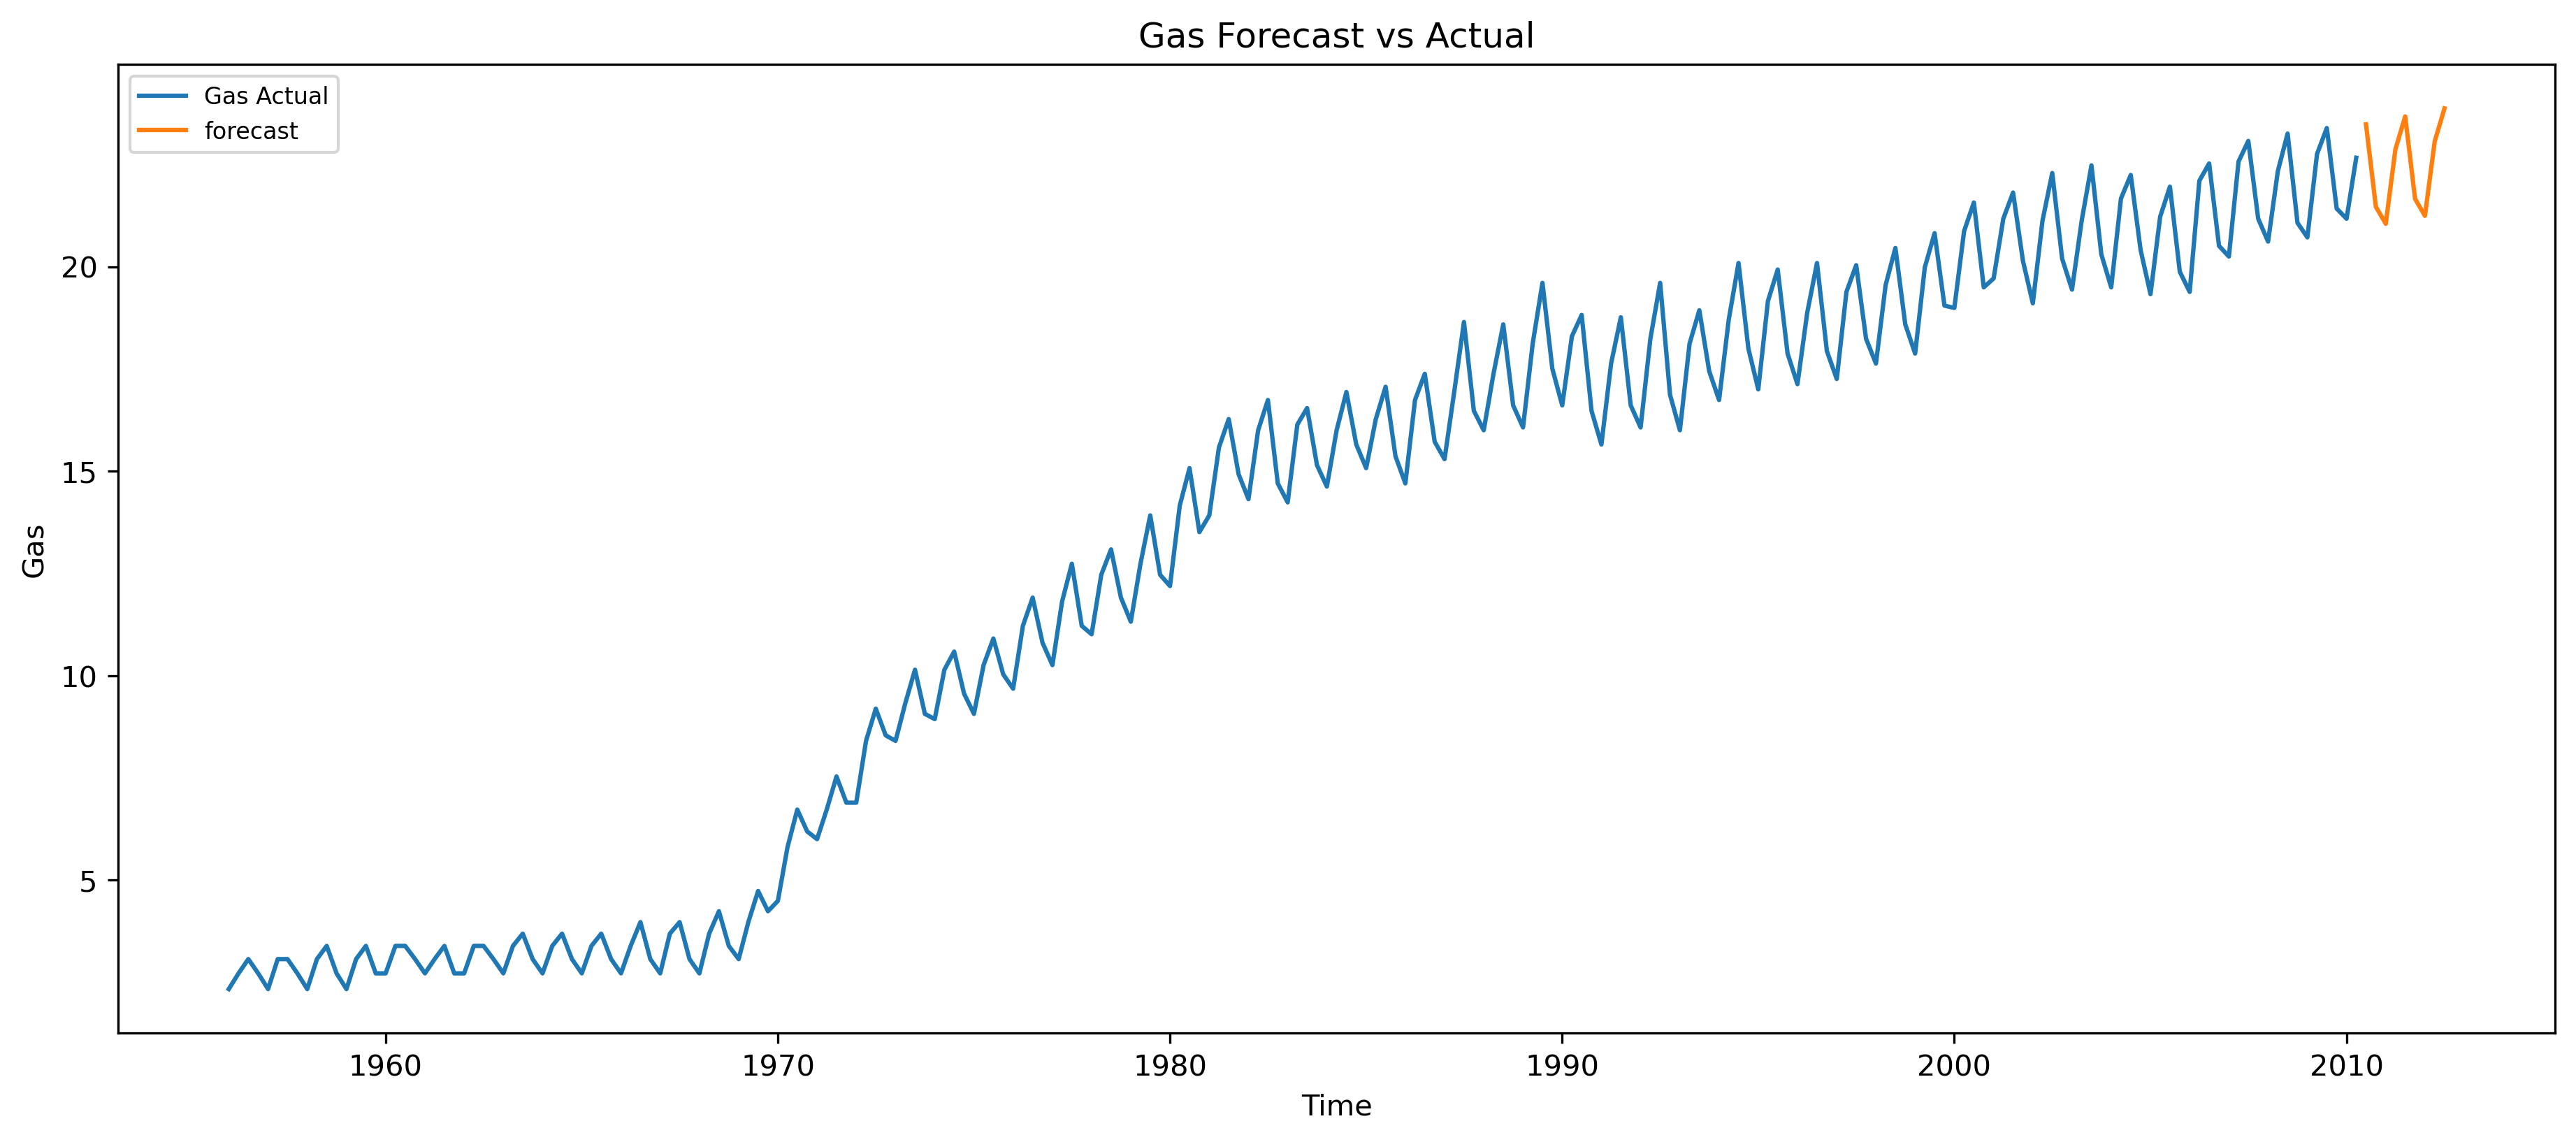

In [74]:
fc_ets_gas = ets_gas.forecast(9)

plt.figure(figsize=(15,6), dpi=300)
plt.plot(gas.bc_gas, label='Gas Actual')
plt.plot(fc_ets_gas, label='forecast')
plt.title('Gas Forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('Time')
plt.ylabel('Gas')
plt.show()

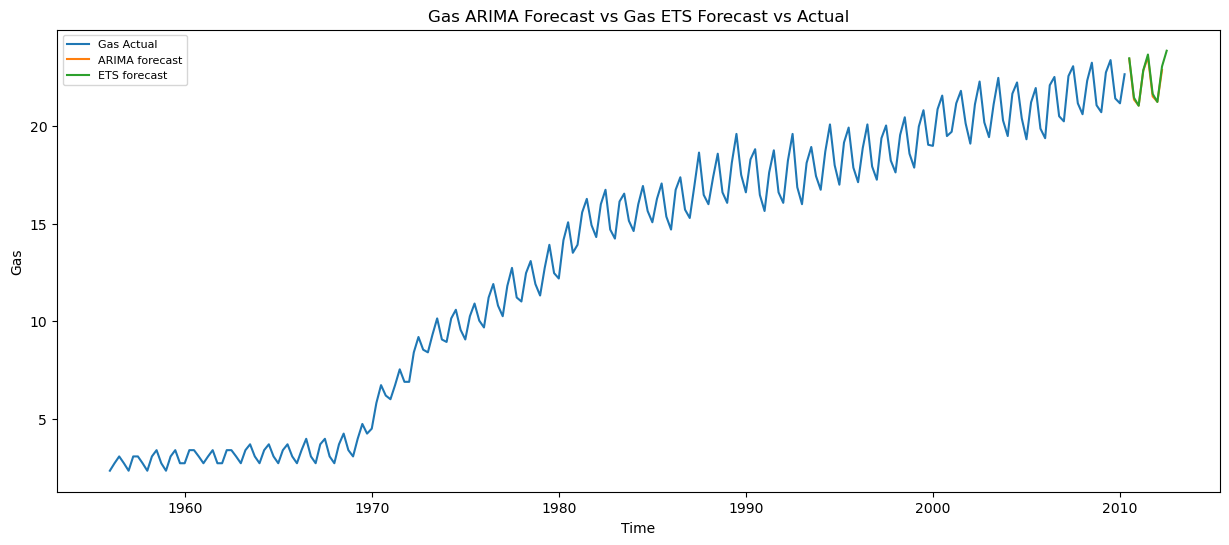

In [75]:
plt.figure(figsize=(15,6), dpi=100)
plt.plot(gas.bc_gas, label='Gas Actual')
plt.plot(fc_series2, label='ARIMA forecast')
plt.plot(fc_ets_gas, label='ETS forecast')
plt.title('Gas ARIMA Forecast vs Gas ETS Forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('Time')
plt.ylabel('Gas')
plt.show()

The forecasts from the ARIMA and ETS model are almost identical.

In [76]:
print(fc)

2010-07-01    23.450939
2010-10-01    21.367445
2011-01-01    21.061329
2011-04-01    22.846092
2011-07-01    23.550890
2011-10-01    21.529203
2012-01-01    21.253939
2012-04-01    22.880895
2012-07-01    23.629610
Freq: QS-OCT, Name: predicted_mean, dtype: float64


In [77]:
print(fc_ets_gas)

2010-07-01    23.481610
2010-10-01    21.466085
2011-01-01    21.049831
2011-04-01    22.871518
2011-07-01    23.675953
2011-10-01    21.660428
2012-01-01    21.244174
2012-04-01    23.065860
2012-07-01    23.870296
Freq: QS-OCT, Name: predicted_mean, dtype: float64


-----

### 8)  Problem 8.18

Before doing this exercise, you will need to install the Quandl package in R using install.packages("Quandl") <br>
&nbsp;&nbsp;&nbsp;&nbsp; a. Select a time series from Quandl. Then copy its short URL and import the data using<br> 
&nbsp;&nbsp;&nbsp;&nbsp; y <- Quandl("?????", api_key="?????", type="ts")<br>
&nbsp;&nbsp;&nbsp;&nbsp; (Replace each ????? with the appropriate values.)<br>

&nbsp;&nbsp;&nbsp;&nbsp; b. Plot graphs of the data, and try to identify an appropriate ARIMA model.<br>

&nbsp;&nbsp;&nbsp;&nbsp; c. Do residual diagnostic checking of your ARIMA model. Are the residuals white noise?<br>

&nbsp;&nbsp;&nbsp;&nbsp; d. Use your chosen ARIMA model to forecast the next four years.<br>

&nbsp;&nbsp;&nbsp;&nbsp; e. Now try to identify an appropriate ETS model.<br>

&nbsp;&nbsp;&nbsp;&nbsp; f. Do residual diagnostic checking of your ETS model. Are the residuals white noise?<br>

&nbsp;&nbsp;&nbsp;&nbsp; g. Use your chosen ETS model to forecast the next four years.<br>

&nbsp;&nbsp;&nbsp;&nbsp; h. Which of the two models do you prefer?<br>

In [78]:
import yfinance as yf

In [79]:
tesla = yf.download("TSLA", interval="1mo")['Adj Close']
tesla = pd.DataFrame(tesla)

[*********************100%***********************]  1 of 1 completed


In [80]:
tesla['pct_chg'] = tesla['Adj Close'].pct_change()
tesla = tesla.dropna()

### Test Stationarity
adf = adfuller(tesla['pct_chg'])[1]
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")


p value:7.57046209770493e-05 , Series is Stationary


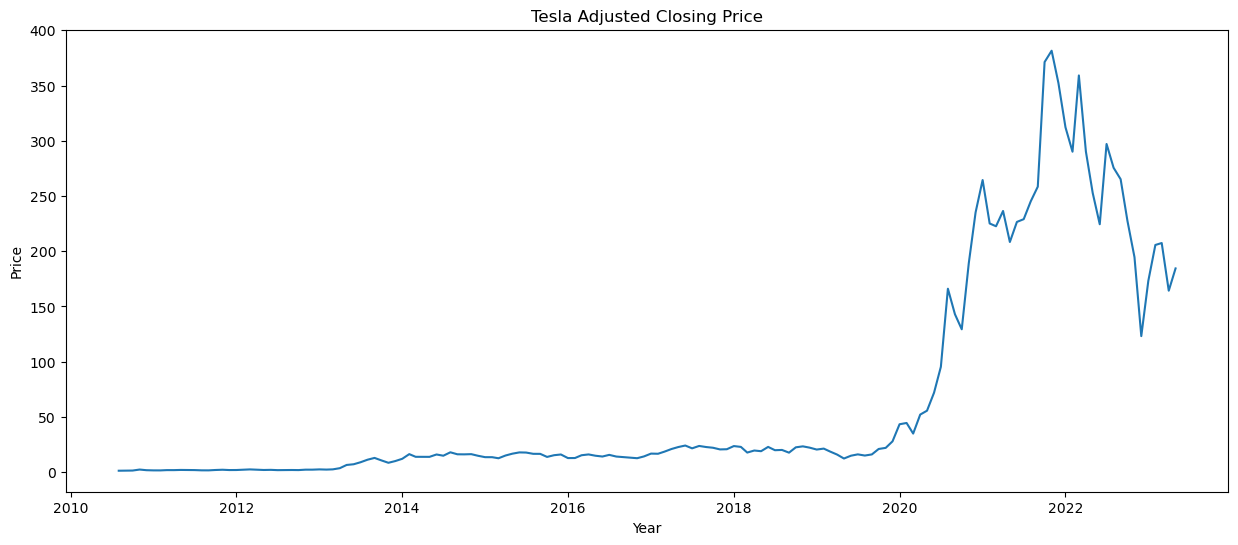

In [81]:
plt.figure(figsize = (15,6))
plt.plot(tesla['Adj Close'])
plt.title('Tesla Adjusted Closing Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

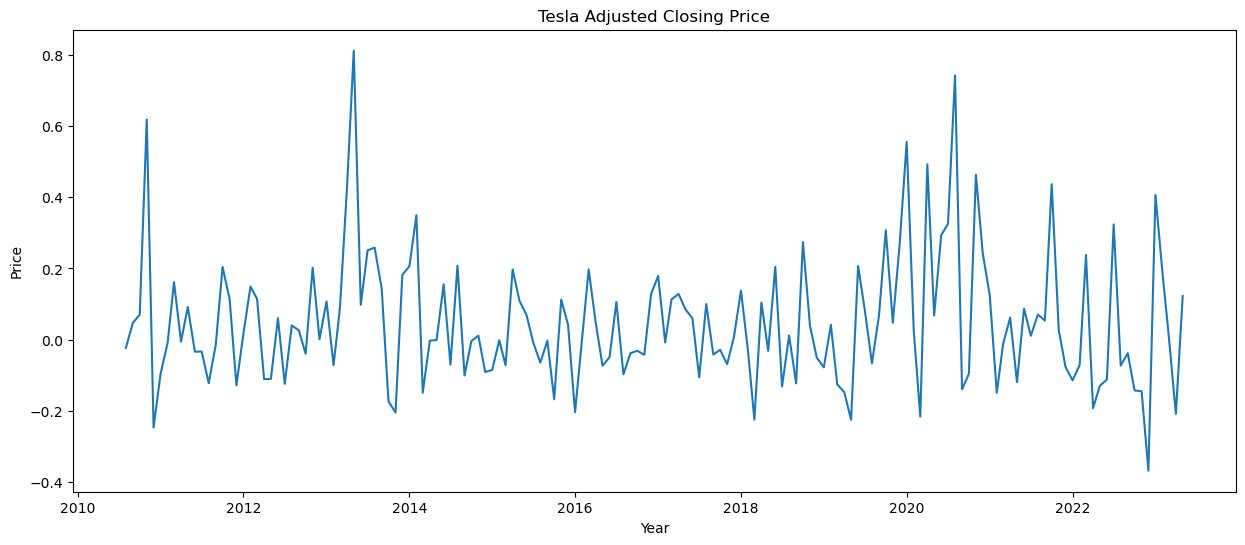

In [82]:
plt.figure(figsize = (15,6))
plt.plot(tesla['pct_chg'])
plt.title('Tesla Adjusted Closing Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

In [83]:
import pmdarima as pm

In [84]:
aarima = pm.auto_arima(tesla['pct_chg'], start_p=0, start_q=0,
                         test='adf',
                         max_p=4, max_q=4, m=12,
                         start_P=0, seasonal=True,
                         D=1, start_Q=0, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

aarima.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=30.530, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-2.980, Time=0.58 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=28.564, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=29.632, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-19.500, Time=1.26 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=-29.320, Time=2.59 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=3.28 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.61 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.73 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=3.28 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(2,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=3.40 sec
 ARIMA(

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                          y   No. Observations:                  154
Model:             SARIMAX(2, 1, [1], 12)   Log Likelihood                  19.764
Date:                    Thu, 25 May 2023   AIC                            -31.528
Time:                            18:19:39   BIC                            -19.705
Sample:                        08-01-2010   HQIC                           -26.724
                             - 05-01-2023                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0496      0.128     -0.388      0.698      -0.300       0.201
ar.S.L24      -0.0748      0.123     -0.606      0.545      -0.317       0.167
ma.S.L12      -0.8862      0.167     -5.300      0.000      -1.214      -0.558
sigma2         0.0384      0.005      7.458      0.000       0.028       0.048
===================================================================================
Ljung-Box (L1) (Q):                   1.84   Jarque-Bera (JB):                27.92
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.83
Prob(H) (two-sided):                  0.22   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

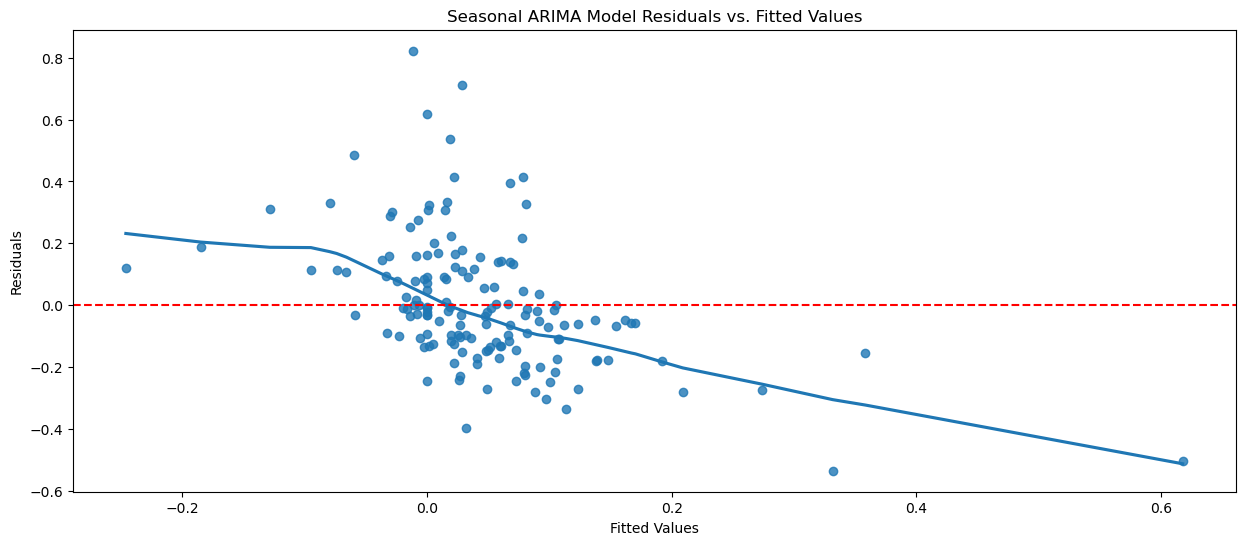

In [85]:
plt.figure(figsize = (15, 6))
plt.title('Seasonal ARIMA Model Residuals vs. Fitted Values')
sns.regplot(x = aarima.fittedvalues(), y = aarima.resid(), lowess = True)
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')
plt.axhline(0, linestyle = '--', color = 'red')

In [86]:
aarima.resid().mean()

0.002724330900398052

In [87]:
np.var(aarima.resid())

0.044201274484287595

Text(0, 0.5, 'ACF')

<Figure size 1500x600 with 0 Axes>

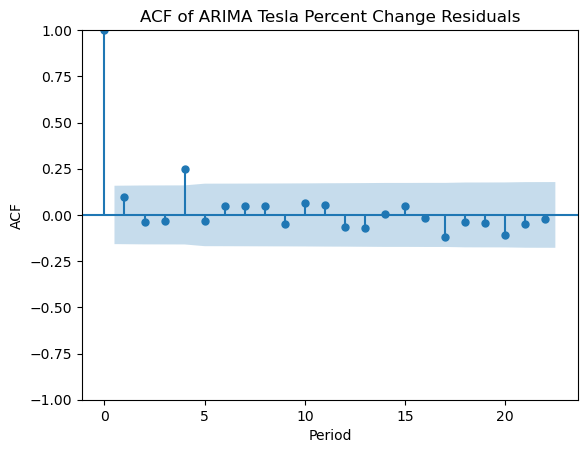

In [88]:
plt.figure(figsize=(15,6))
plot_acf(aarima.resid())
plt.title('ACF of ARIMA Tesla Percent Change Residuals')
plt.xlabel('Period')
plt.ylabel('ACF')

Looking at the residuals, they do resemble white noise. The ACF plot has all periods below the bands except one which is a little unusual but not too problematic.

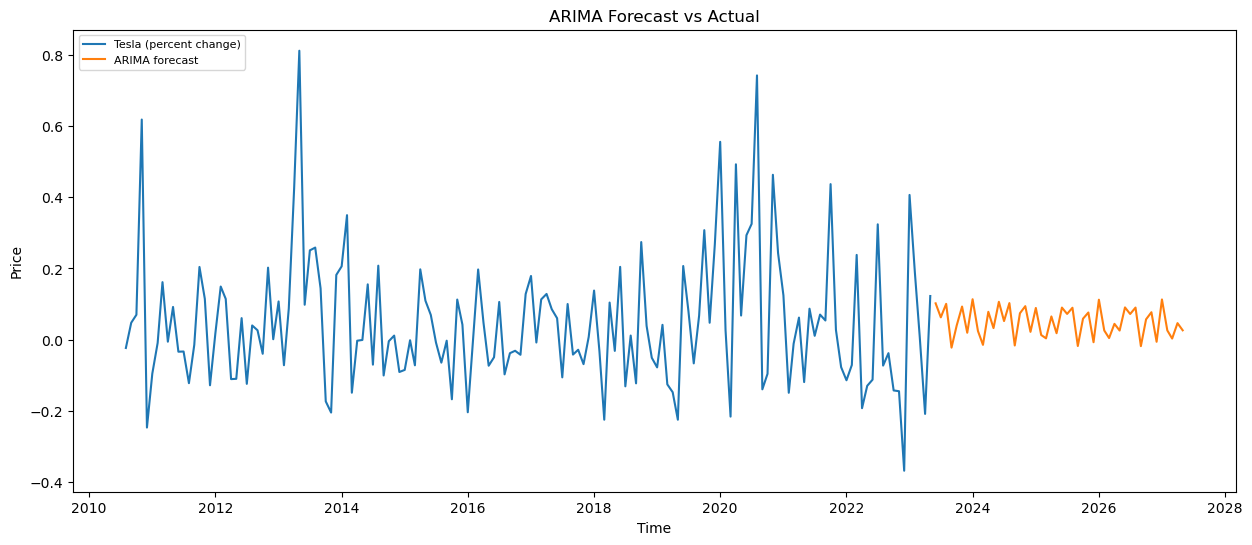

In [89]:
# predict 4 years
fc_tesla_arima = aarima.predict(48)

plt.figure(figsize=(15,6), dpi=100)
plt.plot(tesla['pct_chg'], label='Tesla (percent change)')
plt.plot(fc_tesla_arima, label='ARIMA forecast')
plt.title('ARIMA Forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [90]:
# ETS
tesla.index.freq = pd.infer_freq(tesla.index)
aets=sm.tsa.statespace.ExponentialSmoothing(tesla['pct_chg'],
                                           trend=True, 
                                           initialization_method= 'heuristic', 
                                           seasonal=12, 
                                           damped_trend=False).fit()
print(aets.summary())

                        Exponential Smoothing Results                         
Dep. Variable:                pct_chg   No. Observations:                  154
Model:                   ETS(A, A, A)   Log Likelihood                  34.603
Date:                Thu, 25 May 2023   AIC                            -61.206
Time:                        18:19:40   BIC                            -49.058
Sample:                    08-01-2010   HQIC                           -56.271
                         - 05-01-2023   Scale                            0.037
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.0897      0.027      3.265      0.001       0.036       0.143
smoothing_trend        0.0002      0.001      0.169      0.866      -0.002       0.002
smoothing_seasonal  

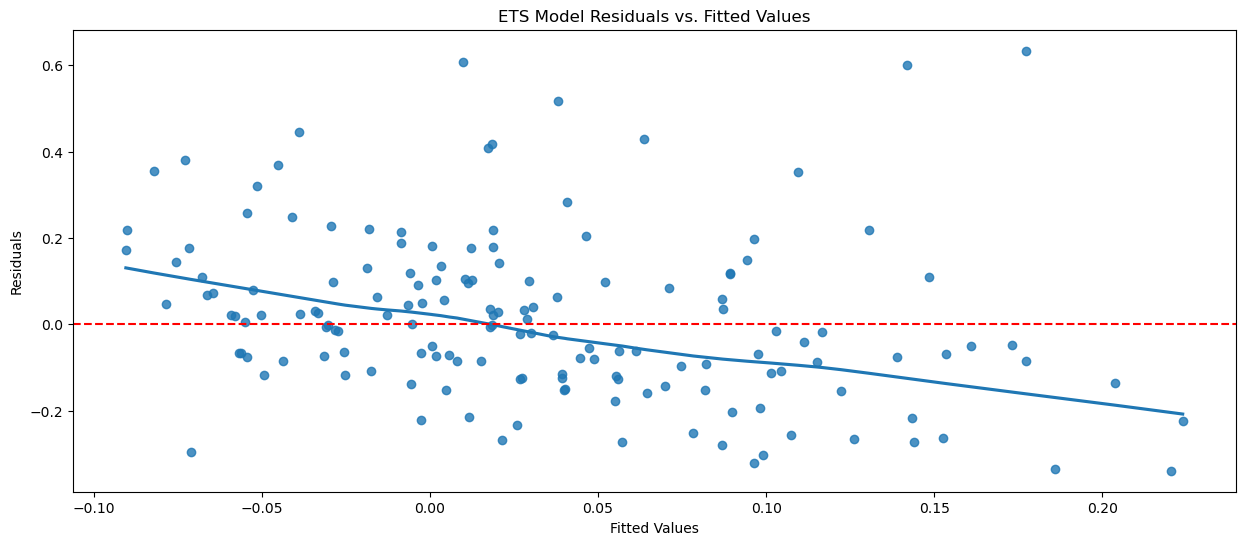

In [91]:
plt.figure(figsize = (15, 6))
plt.title('ETS Model Residuals vs. Fitted Values')
sns.regplot(x = aets.fittedvalues, y = aets.resid, lowess = True)
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')
plt.axhline(0, linestyle = '--', color = 'red')

Text(0, 0.5, 'ACF')

<Figure size 1500x600 with 0 Axes>

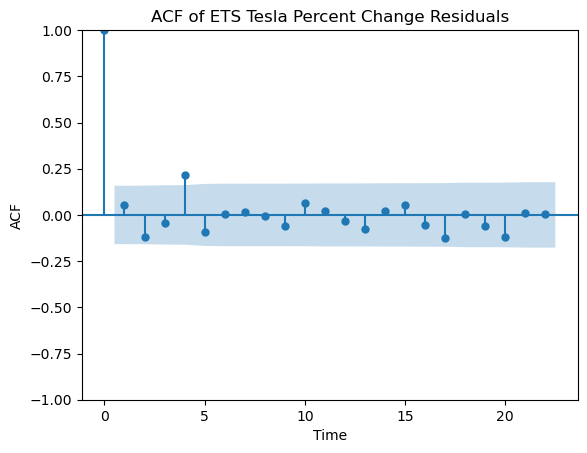

In [92]:
plt.figure(figsize=(15,6))
plot_acf(aets.resid)
plt.title('ACF of ETS Tesla Percent Change Residuals')
plt.xlabel('Time')
plt.ylabel('ACF')

Similar to the ARIMA model, the residuals for the ETS model also appear to be white noise. There is one spike that is statistically significant but again, it isn't too problematic since the remaning spikes are all below the bands.

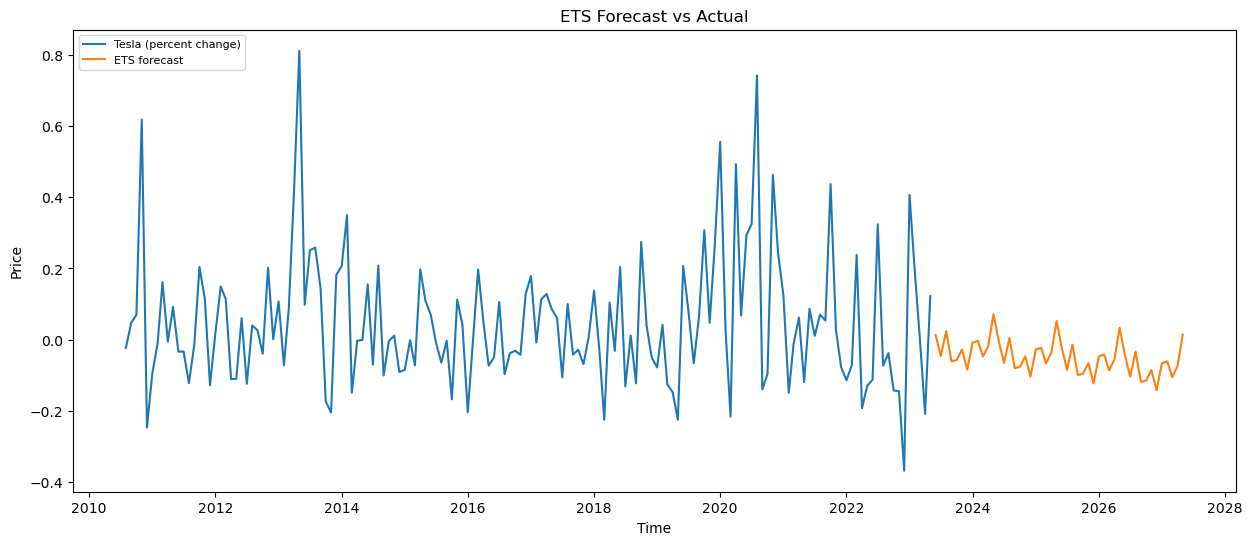

In [93]:
fc_tesla_ets = aets.forecast(48)

plt.figure(figsize=(15,6), dpi=100)
plt.plot(tesla['pct_chg'], label='Tesla (percent change)')
plt.plot(fc_tesla_ets, label='ETS forecast')
plt.title('ETS Forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

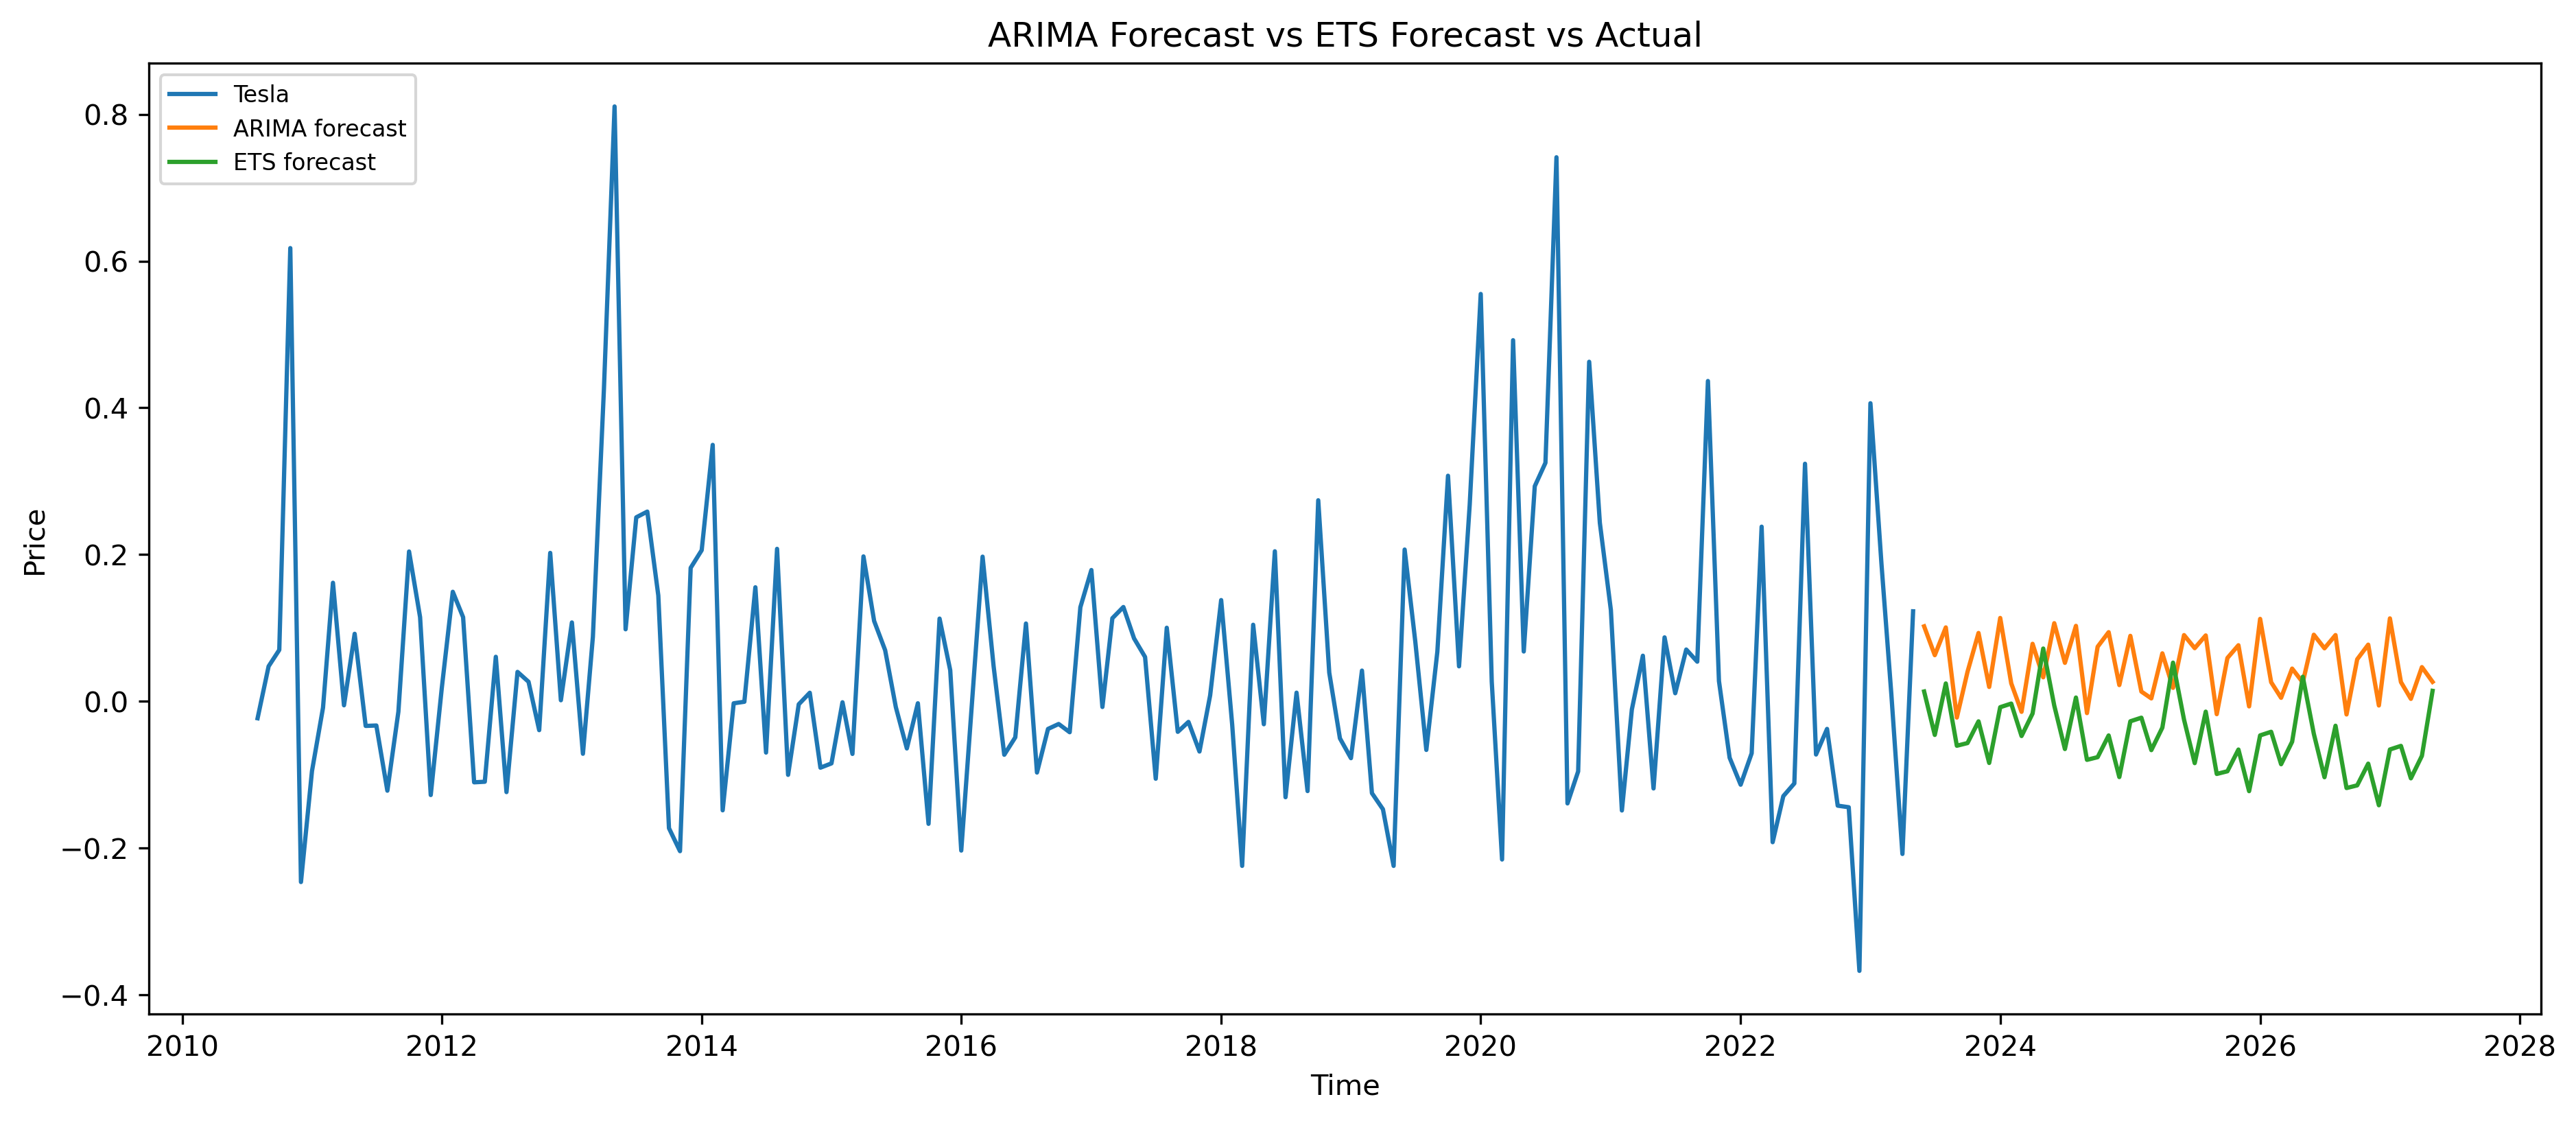

In [94]:
# Combining ARIMA and ETS Forecasts
plt.figure(figsize=(15,6), dpi=300)
plt.plot(tesla['pct_chg'], label='Tesla')
plt.plot(fc_tesla_arima, label='ARIMA forecast')
plt.plot(fc_tesla_ets, label='ETS forecast')
plt.title('ARIMA Forecast vs ETS Forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

Both ARIMA and the ETS model are very similar but I prefer the ARIMA model. The ARIMA forecast has a lower AIC score than the ETS model and its ma.S.12 lag response variable is statistically significant.

<Axes: xlabel='Date', ylabel='Values'>

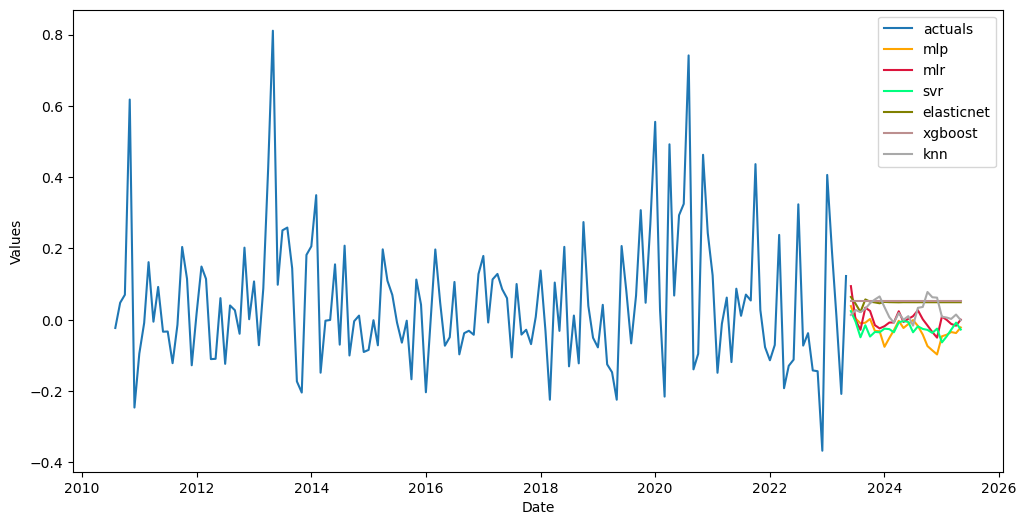

In [95]:
from scalecast import GridGenerator
from scalecast.Forecaster import Forecaster

models = ('mlr','knn','svr','xgboost','elasticnet','mlp')

# df = pdr.get_data_fred('HOUSTNSA',start='2009-01-01',end='2021-06-01')
GridGenerator.get_example_grids()
f = Forecaster(y=tesla['pct_chg'],current_dates=tesla.index) # to initialize, specify y and current_dates (must be arrays of the same length)
f.set_test_length(12) # specify a test length for your models - do this before eda
f.generate_future_dates(24) # this will create future dates that are on the same interval as the current dates and it will also set the forecast length
f.add_ar_terms(4) # add AR terms before differencing
f.add_AR_terms((2,12)) # seasonal AR terms
# f.integrate() # automatically decides if the y term and all ar terms should be differenced to make the series stationary
f.add_seasonal_regressors('month',raw=False,sincos=True) # uses pandas attributes: raw=True creates integers (default), sincos=True creates wave functions
f.add_seasonal_regressors('year')
f.add_covid19_regressor() # dates are flexible, default is from when disney world closed to when US CDC lifted mask recommendations
f.add_time_trend()
f.set_validation_length(6) # length, different than test_length, to tune the hyperparameters 
f.tune_test_forecast(models)
f.plot(order_by='TestSetRMSE',ci=True) # plots the forecast

Here we see that various models being used to forecast the time series. Using RMSE, mlr and svr are performing best. These two models resemble the results we acquired from ARIMA and ETS forecasting methods.